# 28/06/2022 (Dùng Colab để thấy Table of contents)
--------------------------------------------------------------------------------

# 1 Tổng quan về dự án hs code:

## 1.1 Thông tin dự án:

### 1.1.1 Thông tin tổng quát:



1. HS Code  = Harmonized System Code = Mã dùng để phân loại hàng hóa, nó có thể có nhiều loại format khác nhau, hiện tại đang tuân theo format của biểu mẫu thuế XNK 2021 (bên dưới có link). Chi tiết: 
>* Child HS Code: 12345678
>* Chương: 12
>* Parent: 1234
>* Sub-parent: 123456
>* Phân vị: Phần (không thể hiện trong hs code) > Chương (2 số đầu) > Parent (4 số đầu) > Sub-parent (6 số đầu) > Child HS Code (8 số)
>* Lưu ý: Sẽ có trường hợp chỉ có sub-parent mà không có child hs code.
2. Sử dụng mã này để xác định loại hàng (ở mức child hs code), từ đó xác định mức thuế cho mặt hàng được nhập. Như vậy một sản phẩm đồng thời có thể được phân vào nhiều loại mặt hàng khác nhau, khi dự đoán cần ưu tiên loại mã cho mức thuế hợp lý.
3. Đây là bài toán NLP có yêu cầu:

>*   Input: Tên sản phẩm
>*   Output: hs code của sản phẩm đó (có thể cung cấp 1 hoặc nhiều hs code khác nhau)










### 1.1.2 Thông tin dữ liệu:

Hiện tại để tạo được dữ liệu huấn luyện cần 2 file (server 178):

1.   File 1: dữ liệu được crawl từ Amazon: /data_science/data_science/data/v1/data_hscode_31102021/data_hscode_186_01112021/data_full_amazone/quylt_06082021_full_amazon_products_of_all_countries.csv

2.   File 2: dữ liệu dùng để tìm hs code dựa trên node_id: /data_science/data_science/data/v1/data_hscode_31102021/data_hscode_186_01112021/data_full_amazone/hscode+category_fado.csv (lưu ý tên file có chứa dấu '+')

Ngoài ra có thể tham khảo thêm **file biểu mẫu thuế** để kiểm tra sự chính xác của file số 2: https://view.officeapps.live.com/op/view.aspx?src=https%3A%2F%2Fdichvuhaiquan.com.vn%2Fwp-content%2Fuploads%2F2021%2F06%2FBIEU-THUE-XNK-2021.06.22.xlsx&wdOrigin=BROWSELINK


## 1.2 Tổng quan luồng xử lý:

### 1.2.1 Xử lý trước khi join file 1 và file 2

Xử lý cơ bản ở mỗi file:
>1. Chọn trường và đổi tên cho phù hợp
>2. Phân tích dữ liệu
>3. Xóa dữ liệu trống như N/A, None, NaN... 

Xử lý ở file 1:
>1. Chọn giá trị "U.S" trong trường "country_code"
>2. Kiểm tra format của trường node_id (cần sử dụng để tìm child_hscode tương ứng)
>3. Kiểm tra  và xử lý ngôn ngữ trường 'name'
>4. Kiểm tra phân bố độ dài của các giá trị trường 'name'

Xử lý ở file 2:
>1. Kiểm tra và xóa các child_hscode, parent_hscode có format không phù hợp (nếu có)
>2. Kiểm độ chính xác giữa 2 trường child_hscode và parent_hscode

### 1.2.2 Join file 1 và file 2

Join 2 file lại: 
>1. Join dataframe dựa trên trường node_id
>2. Ở file 1 lấy các trường: sku, name, node_id
>3. Ở file 2 lấy các trường: node_id, child_hscode, parent_hscode, name, sku

Xử lý sau khi join:
>1. Thực hiện phân tích và thống kê.
>2. Crawl dữ liệu
>3. Ghép lại với dữ liệu mới

### 1.2.3 Xử lý nâng cao sau khi join file 1 và file 2

1. Xử lý dữ liệu ở trường name:
>*   length <= 2 kí tự: xóa
>*   2 < length <= 3, 4, 5 kí tự: chỉ giữ vật phẩm thuộc **nhóm sách, công nghệ, movie, game**
2. Xử lý dữ liệu trùng lặp theo 6 trường hợp:
>*   Trường hợp 1: Trùng name, trùng node_id, trùng sku
>*   Trường hợp 2: Khác name, trùng node_id, trùng sku
>*   Trường hợp 3: Trùng tên, trùng sku, khác node_id
>*   Trường hợp 4: Khác tên, trùng sku, khác node_id (đã xử lý ở trường hợp 2+3)
>*   Trường hợp 5: Trùng tên, khác sku, trùng node_id
>*   Trường hợp 6: Trùng tên, khác sku, khác node_id
3. Gom dữ liệu thành các nhóm dựa trên phân tích thống kê của trường children_hscode





# 2 Xử lý dữ liệu

In [1]:
import numpy as np
import pandas as pd
import math

## 2.1 Xử lý dữ liệu trước khi join

### 2.1.1 Xử lý cơ bản

#### File 1

In [2]:
full_df=pd.read_csv("/data_science/data_science/data/v1/data_hscode_31102021/data_hscode_186_01112021/data_full_amazone/quylt_06082021_full_amazon_products_of_all_countries.csv",dtype='str')

Vì mục đích minh họa, sau đây chỉ lấy 100000 dòng của file gốc để xử lý

In [3]:
sample_df = full_df.sample(1000000,random_state=1)

In [4]:
sample_df = full_df

Dataframe có tổng cộng 7 trường:
>1. product_id: id của vật phẩm, mỗi vật phẩm có một id duy nhất (unique) - đã check lúc trước
>2. website_code: mã website (luôn là AMAZON) - đã check lúc trước
>3. country_code: có 4 giá trị: "US", "UK", "JP", "DE" - đã check lúc trước
>4. sku: mã lưu trữ của sản phẩm (có thể trùng) - đã check lúc trước
>5. name: tên sản phẩm (có thể trùng) - đã check lúc trước
>6. node_id: mã ngành hàng (có thể trùng) - đã check lúc trước
>7. node_name: tên ngành hàng (có thể trùng) - đã check lúc trước

Trong 7 trường này, chỉ sử dụng 4 trường để xử lý tiếp, là 'sku', ' country_code', 'name', 'node_id'. Lý do chọn các trường là:
>1. sku: có thể dùng giá trị này để tìm sản phẩm và loại đi các sản phẩm trùng lặp
>2. country_code: dùng để lựa chọn ngôn ngữ mà tên sản phẩm được thể hiện bằng.
>3. name: tên sản phẩm, dùng để huấn luyện mô hình
>4. node_id: mã ngành hàng, dùng để tìm hscode khi join/merge với file 2

In [5]:
sample_df = sample_df[['sku','name','node_id','country_code','node_name']]
sample_df

sku                                               name  \
0         B001RNNBCS  Armitron Sport Men's 408159BLK Chronograph Bla...   
1         B00BSZBEAG  Anthony's Organic Coconut Flour, 4 lb, Batch T...   
2         B07HF5SN4T   Vance & Hines VO2 Cage Fighter Air Cleaner 70066   
3         B000J17V52  Swarovski Crystal Figurine, Swan, 2005 Release...   
4         B013PWQN1Y  Amazon Basics 4K Mini DisplayPort to DisplayPo...   
...              ...                                                ...   
32539396  B00DDE02BW        Tomica initial D AE86 Trueno (japan import)   
32539397  B08BKS6T57        BUNKER 27 United States Space Force T-Shirt   
32539398  B098XPQ8NF  Teapot Cup Saucer Set Afternoon Tea Or Coffee ...   
32539399  B004KKX7II  Tomica Long Type Tomica No.126 Thomas the Tank...   
32539400  B0050R0XEG  LEGO Creator 10220 Building Game Volkswagen T1...   

              node_id country_code                    node_name  
0         15494460011           US                Sport Watches  
1            16317621           US               Flours & Meals  
2           404753011           US                  Air Filters  
3             1095304           US        Collectible Figurines  
4              464418           US                 Video Cables  
...               ...          ...                          ...  
32539396    364218031           UK                Scaled Models  
32539397   9056987011           US                     T-Shirts  
32539398   3135653011           US            Cup & Saucer Sets  
32539399    364162031           UK  Model Trains & Railway Sets  
32539400  26163129031           UK              Stacking Blocks  

[32539401 rows x 5 columns]

In [6]:
df = sample_df
def missing_percentage(c):
    return (c.isna().mean() * 100).round(8)
def median(c):
    return c.quantile(0.5).round(1)
def num_values(df):
    return df.nunique()
#def value_percentages(c):
#    return dict((c.value_counts(normalize=True) * 100).round(1))
#df.agg([missing_percentage, num_values, value_percentages])
df.agg([missing_percentage, num_values])

sku          name  node_id  country_code  node_name
missing_percentage         0.0  1.229300e-04      0.0           0.0        0.0
num_values          26882184.0  2.386754e+07  68701.0           4.0    28750.0

Dựa trên số lượng giá trị trong mỗi trường phát hiện thiếu trong trường name và có sự trùng lặp trong cả 'sku', 'name' và 'node_id'.

Cần loại bỏ giá trị trống ở trường **name**:

In [7]:
sample_df = sample_df.dropna(subset=['name'])

#### File 2

In [8]:
mapping_file = pd.read_csv("/data_science/data_science/data/v1/data_hscode_31102021/data_hscode_186_01112021/data_full_amazone/hscode+category_fado.csv",dtype='str')

In [9]:
mapping_file.columns

Index(['category_id', 'parent_id', 'node_id', 'Unnamed: 3', 'Đã sửa',
       'Diễn giải', 'parent_hscode', 'language', 'category_name',
       'category_slug', 'category_name_vn', 'category_slug_vn',
       'category_tree', 'category_depth', 'category_image',
       'category_description', 'category_weight', 'category_note',
       'meta_title', 'meta_keyword', 'meta_description', 'ordering', 'banned',
       'is_deleted', 'is_specialized', 'created_date', 'updated_date'],
      dtype='object')

Có tổng cộng 27 trường dữ liệu, nhưng hiện tại chỉ sử dụng 4 trường:
>1. node_id: mã ngành hàng, dùng để join/merge với file 1
>2. 'Unnamed: 3': child_hscode của sản phẩm
>3. parent_hscode: parent_hscode của sản phẩm
>4. category_name: tên ngành hàng (theo phân loại trên Amazon)
>5. category_tree: cây phân loại ngành hành, bổ sung thêm thông tin cho tên ngành hàng

In [10]:
df = mapping_file
def missing_percentage(c):
    return (c.isna().mean() * 100).round(1)
def median(c):
    return c.quantile(0.5).round(1)
def num_values(df):
    return df.nunique()
def value_percentages(c):
    return dict((c.value_counts(normalize=True) * 100).round(1))
df.agg([missing_percentage, num_values, value_percentages])

category_id  \
missing_percentage                                                0.0   
num_values                                                      50178   
value_percentages   {'1': 0.0, '33458': 0.0, '33460': 0.0, '33461'...   

                                                            parent_id  \
missing_percentage                                                0.4   
num_values                                                       9408   
value_percentages   {'5521': 0.2, '0': 0.2, '10681': 0.1, '5649': ...   

                                                              node_id  \
missing_percentage                                               22.8   
num_values                                                      28791   
value_percentages   {'0': 0.2, '2407763011': 0.0, '14291681': 0.0,...   

                                                           Unnamed: 3  \
missing_percentage                                               22.9   
num_values                                                       2125   
value_percentages   {'49019990': 11.2, '49019910': 4.4, '95049099'...   

                                   Đã sửa  \
missing_percentage                   93.3   
num_values                              2   
value_percentages   {'x': 99.9, 'X': 0.1}   

                                                            Diễn giải  \
missing_percentage                                                0.0   
num_values                                                       1118   
value_percentages   {'0': 22.9, 'BỘT GIẤY TỪ GỖ HOẶC TỪ NGUYÊN LIỆ...   

                                                        parent_hscode  \
missing_percentage                                                0.0   
num_values                                                        686   
value_percentages   {'0': 22.9, '4901': 12.2, '9504': 3.7, '9506':...   

                         language  \
missing_percentage            0.0   
num_values                      1   
value_percentages   {'us': 100.0}   

                                                        category_name  \
missing_percentage                                                0.0   
num_values                                                      23327   
value_percentages   {'General': 1.0, 'Accessories': 0.7, 'Pants': ...   

                                                        category_slug  ...  \
missing_percentage                                                0.0  ...   
num_values                                                      23224  ...   
value_percentages   {'general': 1.0, 'accessories': 0.7, 'pants': ...  ...   

                     category_note meta_title meta_keyword meta_description  \
missing_percentage           100.0      100.0        100.0            100.0   
num_values                       1          0            0                0   
value_percentages   {'0.5': 100.0}         {}           {}               {}   

                                                             ordering  \
missing_percentage                                                0.0   
num_values                                                         12   
value_percentages   {'999999': 88.2, '0': 11.5, '1': 0.0, '2': 0.0...   

                                   banned              is_deleted  \
missing_percentage                    0.0                     0.0   
num_values                              2                       2   
value_percentages   {'0': 99.8, '1': 0.2}  {'0': 100.0, '1': 0.0}   

                   is_specialized  \
missing_percentage            0.0   
num_values                      1   
value_percentages    {'0': 100.0}   

                                                         created_date  \
missing_percentage                                                0.0   
num_values                                                      11274   
value_percentages   {'1407496468': 0.1, '1407497012': 0.1, '140749...   

                                   

Cần loại bỏ giá trị trống ở <strong>node_id</strong> và <strong>child_hscode</strong> (Unnamed: 3)

In [11]:
import math
mapping_file = mapping_file.dropna(subset=['node_id','Unnamed: 3','parent_hscode'])

In [12]:
mapping_file.sample(10)

category_id parent_id     node_id Unnamed: 3 Đã sửa  \
25108       25122     25116  8906583011   82075000    NaN   
20763       20777     20766   379522011   84311013    NaN   
31217       31231     31228     3416371   95069900    NaN   
21366       21380     21378  5486423011   94059990    NaN   
4380         4394      4392     3400811   63069000    NaN   
7091         7105      7103    11059251   33049990    NaN   
625           631       586     1045424   62089990      x   
27069       27083     27079   317987011   90272010    NaN   
7021         7035      7026   382803011   33059000    NaN   
31986       32000     31993  2420077011   61151090    NaN   

                                               Diễn giải parent_hscode  \
25108  KIM LOẠI CƠ BẢN VÀ CÁC SẢN PHẨM BẰNG KIM LOẠI ...          8207   
20763  MÁY VÀ CÁC TRANG THIẾT BỊ CƠ KHÍ;THIẾT BỊ ĐIỆN...          8431   
31217             HScode không có trong dữ liệu hải quan          9506   
21366  CÁC MẶT HÀNG KHÁC. Đồ nội thất; bộ đồ giường, ...          9405   
4380              HScode không có trong dữ liệu hải quan          6306   
7091   SẢN PHẨM CỦA NGÀNH CÔNG NGHIỆP HOÁ CHẤT HOẶC C...          3304   
625    NGUYÊN LIỆU DỆT VÀ CÁC SẢN PHẨM DỆT. Quần áo v...          6108   
27069  DỤNG CỤ, THIẾT BỊ VÀ MÁY QUANG HỌC, NHIẾP ẢNH,...          9027   
7021   SẢN PHẨM CỦA NGÀNH CÔNG NGHIỆP HOÁ CHẤT HOẶC C...          3305   
31986  NGUYÊN LIỆU DỆT VÀ CÁC SẢN PHẨM DỆT. Quần áo v...          6115   

      language             category_name             category_slug  ...  \
25108       us  Indexable Insert Holders  indexable-insert-holders  ...   
20763       us                  Shackles                  shackles  ...   
31217       us                     Decks                     decks  ...   
21366       us              Hanging Rods              hanging-rods  ...   
4380        us           Cots & Hammocks             cots-hammocks  ...   
7091        us                      Face                      face  ...   
625         us         Sleepwear & Robes           sleepwear-robes  ...   
27069       us   Electrophoresis Systems   electrophoresis-systems  ...   
7021        us       Hair Styling Serums       hair-styling-serums  ...   
31986       us               Leg Warmers               leg-warmers  ...   

      category_note meta_title meta_keyword meta_description ordering banned  \
25108           NaN        NaN          NaN              NaN   999999      0   
20763           NaN        NaN          NaN              NaN   999999      0   
31217           NaN        NaN          NaN              NaN   999999      0   
21366           NaN        NaN          NaN              NaN   999999      0   
4380            NaN        NaN          NaN              NaN   999999      0   
7091            NaN        NaN          NaN              NaN   999999      0   
625             NaN        NaN          NaN              NaN   999999      0   
27069           NaN        NaN          NaN              NaN   999999      0   
7021            NaN        NaN          NaN              NaN   999999      0   
31986           NaN        NaN          NaN              NaN   999999      0   

      is_deleted is_specialized created_date updated_date  
25108          0              0   1407496906          NaN  
20763          0              0   1407496822          NaN  
31217          0              0   1407497017          NaN  
21366          0              0   1407496834          NaN  
4380           0              0   1407496517          NaN  
7091           0              0   1407496568          NaN  
625            0              0   1407496445          NaN  
27069          0              0   1407496943          NaN  
7021           0              0   1407496567          NaN  
31986          0              0   1407497032          NaN  

[10 rows x 27 columns]

### 2.1.2 Xử lý riêng mỗi file

#### File 1

##### 1. Chọn giá trị US trong trường country_code

Lý do chọn giá trị US trong trường country_code là do các mặt hàng từ Amazon US đa dạng và nhiều nhất và tiếng Anh là ngôn ngữ dễ xử lý nhất. Một số vấn đề còn lại:
>1. Mất một lượng lớn dữ liệu (khi bỏ các dòng có giá trị khác US trong trường country_code)
>2. Một số tên sản phẩm có chứa ngôn ngữ khác (tên phụ của sản phẩm).

In [13]:
sample_df = sample_df[sample_df.country_code=='US']
sample_df

sku                                               name  \
0         B001RNNBCS  Armitron Sport Men's 408159BLK Chronograph Bla...   
1         B00BSZBEAG  Anthony's Organic Coconut Flour, 4 lb, Batch T...   
2         B07HF5SN4T   Vance & Hines VO2 Cage Fighter Air Cleaner 70066   
3         B000J17V52  Swarovski Crystal Figurine, Swan, 2005 Release...   
4         B013PWQN1Y  Amazon Basics 4K Mini DisplayPort to DisplayPo...   
...              ...                                                ...   
32539393  B07KJFMHJ4  Max2co Women 2 Piece Outfits Floral Long Sleev...   
32539394  B08P4Y7VS3  HICTOP CR-10 Glass Bed Double Sided Upgraded T...   
32539395  B097H74JKK  Anzy Front Headlight Lens Cover, Motorcycle Fr...   
32539397  B08BKS6T57        BUNKER 27 United States Space Force T-Shirt   
32539398  B098XPQ8NF  Teapot Cup Saucer Set Afternoon Tea Or Coffee ...   

              node_id country_code               node_name  
0         15494460011           US           Sport Watches  
1            16317621           US          Flours & Meals  
2           404753011           US             Air Filters  
3             1095304           US   Collectible Figurines  
4              464418           US            Video Cables  
...               ...          ...                     ...  
32539393      1040660           US                Clothing  
32539394   8481419011           US  3D Printer Accessories  
32539395     15736471           US            Light Covers  
32539397   9056987011           US                T-Shirts  
32539398   3135653011           US       Cup & Saucer Sets  

[19078865 rows x 5 columns]

##### 2. Kiểm tra format của node_id

Lưu ý thấy các giá trị của **node_id là dạng số**, do đó sẽ kiểm tra format bằng cách xem các giá trị có đồng nhất là dạng số hay không.

In [14]:
sample_df['check_numeric']=sample_df.node_id.apply(lambda x:x.isnumeric())

In [15]:
sample_df[sample_df.check_numeric==False]

sku                                               name  \
4750      B07PM63193  SL-C6000 Nexus 8-Speed Revo Shifter, Right Han...   
8097      B07C1VR2M1  Shimano Ultegra CI4 5500 XTC Offshore Saltwate...   
8557      0007523106                                LOOTING MACHINE- PB   
10354     0007559224                                          Solitaire   
48136     0141375655                              Two Can Keep a Secret   
...              ...                                                ...   
30549785  B07RN8FCW9  L'Absolu Mademoiselle Shine - 232 Mademoiselle...   
30561463  B004C6U0NU  Daiwa SALD20-2SPD Saltiga 2 Speed Lever Drag S...   
30562572  1509813136                   Poem For Every Night Of The Year   
30580781  B01M4IPXR1  Dr. Brown's Wide Neck Glass Bottle Sleeve, Blu...   
30584196  B00166VEHK  Prannoi Revoltech: 050 Gurren Lagann Action Fi...   

                                    node_id country_code  \
4750      miczone-unknown-original-category           US   
8097      miczone-unknown-original-category           US   
8557      miczone-unknown-original-category           US   
10354     miczone-unknown-original-category           US   
48136     miczone-unknown-original-category           US   
...                                     ...          ...   
30549785  miczone-unknown-original-category           US   
30561463  miczone-unknown-original-category           US   
30562572  miczone-unknown-original-category           US   
30580781  miczone-unknown-original-category           US   
30584196  miczone-unknown-original-category           US   

                                  node_name  check_numeric  
4750      Miczone Unknown Original Category          False  
8097      Miczone Unknown Original Category          False  
8557      Miczone Unknown Original Category          False  
10354     Miczone Unknown Original Category          False  
48136     Miczone Unknown Original Category          False  
...                                     ...            ...  
30549785  Miczone Unknown Original Category          False  
30561463  Miczone Unknown Original Category          False  
30562572  Miczone Unknown Original Category          False  
30580781  Miczone Unknown Original Category          False  
30584196  Miczone Unknown Original Category          False  

[425 rows x 6 columns]

Phát hiện thấy có các giá trị không phải số, do đó cần phải loại bỏ các giá trị này đi.

In [16]:
sample_df = sample_df[sample_df.check_numeric==True]
sample_df

sku                                               name  \
0         B001RNNBCS  Armitron Sport Men's 408159BLK Chronograph Bla...   
1         B00BSZBEAG  Anthony's Organic Coconut Flour, 4 lb, Batch T...   
2         B07HF5SN4T   Vance & Hines VO2 Cage Fighter Air Cleaner 70066   
3         B000J17V52  Swarovski Crystal Figurine, Swan, 2005 Release...   
4         B013PWQN1Y  Amazon Basics 4K Mini DisplayPort to DisplayPo...   
...              ...                                                ...   
32539393  B07KJFMHJ4  Max2co Women 2 Piece Outfits Floral Long Sleev...   
32539394  B08P4Y7VS3  HICTOP CR-10 Glass Bed Double Sided Upgraded T...   
32539395  B097H74JKK  Anzy Front Headlight Lens Cover, Motorcycle Fr...   
32539397  B08BKS6T57        BUNKER 27 United States Space Force T-Shirt   
32539398  B098XPQ8NF  Teapot Cup Saucer Set Afternoon Tea Or Coffee ...   

              node_id country_code               node_name  check_numeric  
0         15494460011           US           Sport Watches           True  
1            16317621           US          Flours & Meals           True  
2           404753011           US             Air Filters           True  
3             1095304           US   Collectible Figurines           True  
4              464418           US            Video Cables           True  
...               ...          ...                     ...            ...  
32539393      1040660           US                Clothing           True  
32539394   8481419011           US  3D Printer Accessories           True  
32539395     15736471           US            Light Covers           True  
32539397   9056987011           US                T-Shirts           True  
32539398   3135653011           US       Cup & Saucer Sets           True  

[19078440 rows x 6 columns]

Như vậy trong 5 trường dữ liệu có 2 trường dữ liệu đã đồng bộ là **country_code** và **check_numeric** --> xóa 2 trường này

In [17]:
sample_df=sample_df[['sku','name','node_id','node_name']]
sample_df

sku                                               name  \
0         B001RNNBCS  Armitron Sport Men's 408159BLK Chronograph Bla...   
1         B00BSZBEAG  Anthony's Organic Coconut Flour, 4 lb, Batch T...   
2         B07HF5SN4T   Vance & Hines VO2 Cage Fighter Air Cleaner 70066   
3         B000J17V52  Swarovski Crystal Figurine, Swan, 2005 Release...   
4         B013PWQN1Y  Amazon Basics 4K Mini DisplayPort to DisplayPo...   
...              ...                                                ...   
32539393  B07KJFMHJ4  Max2co Women 2 Piece Outfits Floral Long Sleev...   
32539394  B08P4Y7VS3  HICTOP CR-10 Glass Bed Double Sided Upgraded T...   
32539395  B097H74JKK  Anzy Front Headlight Lens Cover, Motorcycle Fr...   
32539397  B08BKS6T57        BUNKER 27 United States Space Force T-Shirt   
32539398  B098XPQ8NF  Teapot Cup Saucer Set Afternoon Tea Or Coffee ...   

              node_id               node_name  
0         15494460011           Sport Watches  
1            16317621          Flours & Meals  
2           404753011             Air Filters  
3             1095304   Collectible Figurines  
4              464418            Video Cables  
...               ...                     ...  
32539393      1040660                Clothing  
32539394   8481419011  3D Printer Accessories  
32539395     15736471            Light Covers  
32539397   9056987011                T-Shirts  
32539398   3135653011       Cup & Saucer Sets  

[19078440 rows x 4 columns]

##### 3. Kiểm tra ngôn ngữ trường name

Dù đã chọn giá trị 'US' nhưng tên các sản phẩm vẫn có thể không phải là tiếng Anh, do đó cần kiểm tra và xử lý phù hợp.

Một số thư viện có thể tham khảo: **https://stackoverflow.com/questions/39142778/python-how-to-determine-the-language**
<br>Thư viện lựa chọn sử dụng: **fasttext**

In [18]:
#!pip install fasttext-langdetect

In [19]:
#!pip install wget

In [20]:
# Nếu bỏ dòng (1) sẽ xảy ra lỗi vì một số tên sản phẩm có kí tự "\n"
# --> Cần loại bỏ kí tự này trước khi detect ngôn ngữ
from ftlangdetect import detect
sample_df.name = sample_df.name.apply(lambda x: x.replace("\n"," ") if type(x) is str else print(x) ) #(1)

/tmp/ipykernel_14920/997018733.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df.name = sample_df.name.apply(lambda x: x.replace("\n"," ") if type(x) is str else print(x) ) #(1)


In [21]:
list_dict_lang = sample_df.name.apply(lambda x: detect(x,low_memory=False))

In [22]:
sample_df['language'] = [x['lang'] for x in list_dict_lang]
sample_df['language_score'] = [x['score'] for x in list_dict_lang]

/tmp/ipykernel_14920/3646774786.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['language'] = [x['lang'] for x in list_dict_lang]


In [23]:
#Kiểm tra số lượng ngôn ngữ và tên các ngôn ngữ
print(sample_df.language.unique())
print(len(sample_df.language.unique()))

['en' 'fr' 'ja' 'de' 'it' 'es' 'pt' 'zh' 'ru' 'ceb' 'no' 'sv' 'fi' 'gl'
 'nl' 'oc' 'sk' 'mk' 'eu' 'cs' 'ro' 'pl' 'eo' 'id' 'fa' 'hu' 'da' 'sr'
 'ca' 'sl' 'uk' 'tr' 'et' 'lt' 'war' 'sh' 'bn' 'kk' 'hy' 'la' 'cy' 'th'
 'bs' 'vi' 'fy' 'ar' 'ur' 'lb' 'ko' 'mn' 'ms' 'hr' 'is' 'lv' 'tt' 'br'
 'te' 'kn' 'gd' 'af' 'an' 'nds' 'nn' 'ml' 'he' 'ga' 'sq' 'yi' 'lmo' 'ie'
 'ht' 'ta' 'jbo' 'el' 'bo' 'kw' 'tl' 'sw' 'hi' 'pms' 'bg' 'be' 'gu' 'ku'
 'sco' 'mr' 'mg' 'pa' 'am' 'ka' 'vo' 'mt' 'az' 'qu' 'als' 'uz' 'scn' 'io'
 'gom' 'jv' 'tk' 'my' 'su' 'arz' 'tg' 'sc' 'vec' 'ia' 'azb' 'ne' 'ast'
 'min' 'ky' 'pam' 'rm' 'new' 'ba' 'dv' 'wa' 'eml' 'ps' 'as' 'lo' 'hsb'
 'ckb' 'bar' 'lrc' 'vep' 'ilo' 'si' 'bh' 'gn' 'pnb' 'wuu' 'bcl' 'li' 'so'
 'lez']
138


<AxesSubplot:>

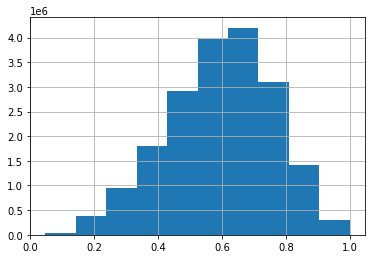

In [24]:
sample_df.language_score.hist()

<AxesSubplot:>

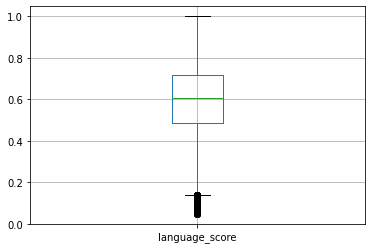

In [25]:
sample_df.boxplot(column=['language_score'])

In [26]:
low_margin = sample_df.language_score.describe()['25%']
high_margin = sample_df.language_score.describe()['75%']
sample_df.language_score.describe()['25%']

0.4854281470179558

Kết quả detect sẽ trả về 2 giá trị (language và language_score), do đó cần xử lý trên cả 2:
>1. Ngôn ngữ của chuỗi (name): nhiều nước khác nhau, ưu tiên chọn giá trị 'en' = 'english'
>2. Score (probability) của ngôn ngữ, cần kiểm tra các trường hợp: 
>> score thấp (< low_margin) + ngôn ngữ 'en' -> có phải 'en' hay không?  
>> score thấp (< ) + ngôn ngữ khác -> ngôn ngữ nào?
>> <br/>score cao + ngôn ngữ 'en' -> đúng ngôn ngữ không?
>> <br/>score cao + ngôn ngữ khác -> đúng ngôn ngữ không?

**score thấp + ngôn ngữ 'en' --> có phải 'en' hay không?**

In [27]:
test_df = sample_df[(sample_df.language == 'en') & (sample_df.language_score <= low_margin)].sample(10)
print("10 tên random:\n ",test_df.name.tolist())
print("Score cho ngôn ngữ 'en' của 10 tên: \n",test_df.language_score.tolist())

10 tên random:
  ['DEER U 1 1/8 inch 3K Super Light Bicycle Carbon Fiber Headset Top Cap & Steel Bolt MTB Bike', 'SOOLALA Ladies Modern Fashion Eyeglass Frame Cat Eye Reading Glass', 'Moranifesto', 'Ekouaer Nightgown Womens Sleeveless Long Nightshirt Full Slip Chemise Nightdress Summer Loose Racerback Lounge Dress', 'NotoCity for Garmin Forerunner 645 Band, 245 Band, 20mm Replacement Strap Soft Silicone for Vivoactive 3 Music Vívomove HR Forerunner 645/245 Music smartwatch', "Bow Dream Flower Girl's Dress Sequins Tulle", 'JINHONG Cute 3D Cartoon Design Soft Wrist Support Office Gaming Mouse Pad for PC&Laptop（Hatsune Miku）', 'Tango Legends', 'Suzuki Outboard Cloth Motor Cover DF150AP/175AP/200A 990C0-65011', 'Extreme Online Store for 2008-2014 Mercedes Benz W204 C63 AMG (Without PDC) Front Tow Hook License Plate Relocated Bracket Holder']
Score cho ngôn ngữ 'en' của 10 tên: 
 [0.4333060383796692, 0.4762669503688812, 0.2888120710849762, 0.39157912135124207, 0.43252331018447876, 0.4052830

Tuy score thấp nhưng vẫn là tiếng Anh, tuy nhiên bị điểm thấp do chứa nhiều kí tự số và các kí tự đặc biệt hoặc tên có số kí tự ít, ví dụ:
- **Chứa nhiều kí tự số**: Husqvarna 2 Pack 539110311 Idler Pulley for EZ4217 EZ4824 EZ5224 RZ4219 RZ5424 - en - 0.3511
- **Tên ngắn**: Lime Lip Balm - en - 0.4691
- **Chứa nhiều kí tự đặc biệt**: Certi-Gauze Pad 632 (211-012) 4" x 4" 2 unitc ; en ; 0.2718

**score thấp + ngôn ngữ khác --> ngôn ngữ nào?**

In [28]:
test_df = sample_df[(sample_df.language != 'en') & (sample_df.language_score <= low_margin)].sample(10)
print("10 tên random:\n ",test_df.name.tolist())
print("Score cho ngôn ngữ của 10 tên: \n",test_df.language_score.tolist())
print("Ngôn ngữ:\n",test_df.language.tolist())

10 tên random:
  ['Dofash 20Pcs 4.5CM/1.77IN Mini Slim Snap Hair Clips Hair Barrettes Hair Accessories for Women Thin Hair（Brown）', 'Skechers Unisex-Child Twinkle Lite-Leopard Glitz Sneaker', 'NOBLESSE EDGE WAX/PREMIUM STYLING POMADE 30ml 2PACK (Extreme Hold 2pack)', 'Sennheiser Pro Audio Sennheiser EW 100-CI1 Instrument Wireless System-A Band (516-558Mhz), 100 G4-CI1-A', 'Liszt - My Piano Hero', 'TYPE 30 SERVICE BRAKE CHAMBER', 'See Kai Run Unisex-Child Dane Sneaker', 'Lolita (FOLIO)', 'Auto Meter 8092 GT Series Electric Voltmeter Gauge', 'NBA Jam']
Score cho ngôn ngữ của 10 tên: 
 [0.30022358894348145, 0.18907272815704346, 0.31889277696609497, 0.29542839527130127, 0.28188779950141907, 0.3109866678714752, 0.28654205799102783, 0.1731451451778412, 0.3143015205860138, 0.16751055419445038]
Ngôn ngữ:
 ['zh', 'fr', 'ja', 'de', 'hu', 'ja', 'fr', 'hu', 'de', 'eo']


Score thấp và ngôn ngữ khác có các trường hợp:
- **Tên riêng (có thể rất ngắn)**: Lacoste 2001054 - MIA ; es ; 0.285
- **Ngôn ngữ khác chiếm đa số**: Savile Biotina Pulpa de Sabila y Aceite de Argon Shampoo/Acondicionador (Shampoo and Conditioner) ; es ; 0.318
- **Tiếng Anh nhưng có nhiều kí tự đặc biệt (hay kí tự số, dấu câu)**: Mini\xa0Backpack\xa0Purse,ChaseChic\xa0Faux\xa0Leather\xa0Women\xa0Convertible\xa0Shoulder\xa0Bag\xa02\xa0ways ; fr ; 0.108081

 **score cao + ngôn ngữ 'en' --> đúng ngôn ngữ không?**

In [29]:
test_df = sample_df[(sample_df.language == 'en') & (sample_df.language_score >= high_margin)].sample(10)
print("10 tên random:\n ",test_df.name.tolist())
print("Score cho ngôn ngữ của 10 tên: \n",test_df.language_score.tolist())
print("Ngôn ngữ:\n",test_df.language.tolist())

10 tên random:
  ['Xperia 5 II Case Design Cotton Model [ PC/TPU/Cotton ] - Fingerprint Prevention Function and Simple Hybrid case, Cotton Design, Shock Resistance, Lightweight - Gray', 'Keter Storage Cabinet with Doors and Shelves - Perfect for Garage and Basement Organization, Grey, 12 Sq Ft', '24 Pack Regular Mouth Canning Mason Jar Lids and Bands, Leak Proof and Secure for Mason Storage Canning Lids', "Bulotus Women's Zip Front V-Neck 3/4 Sleeve Tunic Casual Top", "YAOFAO Men's Gym Clothing Compression Pants Shorts Jacket and Short Sleeve Fitness Set Athletic Wear 4PCS/6PCS", 'LWR CRAFTS Burlap Bunting Banner Triangle Heart MR MRS', 'Prime Brands Group Cell Phone Case for Apple iPhone XR - NFL Licensed Kansas City Chiefs - Red Textured Back Cover on Black TPU Skin', 'How They Got into Harvard', "Men's Danny Sneaker", 'Pervasive Vulnerabilities: Sexual Harassment in School (Adolescent Cultures, School, and Society)']
Score cho ngôn ngữ của 10 tên: 
 [0.7275049090385437, 0.7947645187

Dựa trên giá trị name của các mẫu ngẫu nhiên, tạm nhận định rằng **fasttext detect đúng ngôn ngữ 'en' ở prob cao**. 

**score cao + ngôn ngữ khác 'en' --> đúng ngôn ngữ không?**

In [30]:
test_df = sample_df[(sample_df.language != 'en') & (sample_df.language_score >= high_margin)].sample(10)
print("10 tên random:\n ",test_df.name.tolist())
print("Score cho ngôn ngữ của 10 tên: \n",test_df.language_score.tolist())
print("Ngôn ngữ:\n",test_df.language.tolist())

10 tên random:
  ['La Apple de Tim Cook: Cómo trabaja el enigmático sucesor de Steve Jobs que llevó a Apple a lo más alto (Gestión del conocimiento) (Spanish Edition)', 'Come un uccello su un ramo (Italian Edition)', 'Emper Le chameau ESPADA AZUL for men (pour homme) eau de toilette, vaporisateur natural spray 100ml (3.4 Fl. OZ)', 'Ponyherz 09: Klassenfahrt mit Pony', 'Jesús siempre: Descubre el gozo en su presencia (Jesus Always) (Spanish Edition)', 'Ergotron\xa0–\xa0LX\xa0Sit-Stand\xa0Wall Mount Monitor Arm\xa0–\xa0Polished Aluminum\xa0', 'キャラクタースリーブ だがしかし 遠藤サヤ (EN-217)', "Équipement professionnel long de salon de diode d'impulsion de machine de réduction de ride.", 'adidas - Archivo - EF0417 - Color: Navy Blue - Size: 9.5', 'Queen : Jazz']
Score cho ngôn ngữ của 10 tên: 
 [0.9734721779823303, 0.8060997724533081, 0.7798288464546204, 0.9894444346427917, 0.7596083283424377, 0.8728981614112854, 0.9996085166931152, 0.9560405015945435, 0.7827264666557312, 0.7297579050064087]
Ngôn ngữ:
 ['

Dựa trên giá trị name của các mẫu ngẫu nhiên, tạm nhận định rằng **fasttext detect gần đúng ngôn ngữ khác 'en' ở prob cao**. Vẫn còn **trường hợp name ngắn thì dù tiếng Anh vẫn bị detect thành ngôn ngữ khác**.  

In [31]:
# df = sample_df[['language']]
# def missing_percentage(c):
#     return (c.isna().mean() * 100).round(4)
# def median(c):
#     return c.quantile(0.5).round(1)
# def num_values(df):
#     return df.nunique()
# def value_percentages(c):
#     return dict((c.value_counts(normalize=True) * 100).round(4))
# print("Percentage value of languages:")
# df.agg([missing_percentage, num_values, value_percentages]).loc['value_percentages'].tolist()

**Chú ý** ở phần xử lý các giá trị trong trường name có nhiều các trường hợp cần xử lý, tạm chia chúng ra thành 2 phần:
1. **Phần cần xử lý để làm sạch dữ liệu**, là trường hợp dữ liệu bị lỗi.
2. **Phần cần xử lý để huấn luyện**, là các trường hợp này không phải là lỗi (bản chất dữ liệu là vậy) nhưng nó có thể gây ảnh hưởng trực tiếp đến độ chính xác cũng như việc học của mô hình, cần xử lý để mô hình hoạt động tốt hơn.

##### 3.1. Phần cần xử lý để làm sạch dữ liệu (phần này hiện chưa thực hiện ở phiên bản này):
1. Xử lý các kí tự đặc biệt (hiện mới chỉ phát hiện kí tự \xa0 có trong trường 'name')
> Gợi ý: Sử dụng HTML để decode: https://stackoverflow.com/questions/2360598/how-do-i-unescape-html-entities-in-a-string-in-python-3-1
2. Xử lý các trường hợp tên và sản phẩm không giống nhau. (sẽ gặp ở phần 4 bên dưới)
> Gợi ý: thường tên sai sẽ lưu thành một kí tự, nên có thể xóa đi những sản phẩm có tên quá ít kí tự.

##### 3.2. Phần cần xử lý huấn luyện (sẽ xử lý ở file huấn luyện mô hình - https://gitlab.com/fdcoin/fado-ml-hscode/-/tree/vinh_hscode - trong 2 folder tf-df và glove):
1. Xử lý tên riêng (đã thực hiện)
> Gợi ý: Để xử lý tên riêng nên dùng các phương pháp mã hóa mang thông tin tần số như GloVe (co-ocurence), tf-idf,...
2. Xử lý các trường hợp tên có nhiều kí tự đặc biệt: '/', '@', '(',... (đã xử lý ở file huấn luyện mô hình)
3. Xử lý các trường hợp tên có nhiều số (đã xử lý ở file huấn luyện mô hình)

##### 4. Kiểm tra phân phối của giá trị độ dài trường name

<AxesSubplot:>

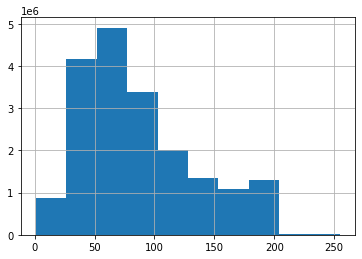

In [32]:
sample_df['name_length'] = sample_df.name.apply(lambda x: len(x))
sample_df.name_length.hist()

<AxesSubplot:>

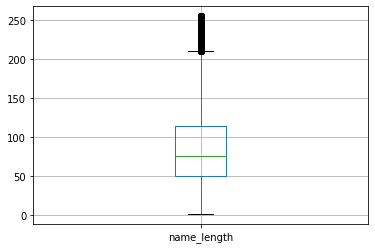

In [33]:
sample_df.boxplot(column=['name_length'])

In [34]:
sample_df.name_length.describe()

count    1.907844e+07
mean     8.660178e+01
std      4.760095e+01
min      1.000000e+00
25%      5.000000e+01
50%      7.500000e+01
75%      1.140000e+02
max      2.550000e+02
Name: name_length, dtype: float64

Từ các thông tin trên có thể thấy rằng độ dài của tên tập trung ở khoảng 50 đến 120 kí tự. Đáng chú ý là vẫn có những tên **chỉ chứa 1 hoặc vài kí tự**, các tên loại này có thể gây nhiễu dữ liệu và cần phải được kiểm tra và xử lý.

In [35]:
sample_df[sample_df.name_length<=10].sample(10)

sku        name      node_id                     node_name  \
7105939   B00TRFEVUY         Nut     13789601  Lawn Mower Replacement Parts   
24114888  9771746464  Abu Simbel        16703                        Africa   
1140043   150840304X  Colorblind        10719          Literature & Fiction   
21755337  B00281HF6Q  Obama Mask  14194736011                         Masks   
2793919   B000S1MIQ0       S & R        63879                        Hawaii   
22627395  B06W5L78DZ    Guzuguzu           34                          Jazz   
4343296   B005EZ5GYQ        NCIS     14210751                 PlayStation 3   
18976719  B07X7L546Y  Conqueror+   9056923011                      T-Shirts   
27558238  B0000032P5    Faithful       408264              Progressive Rock   
30120855  0877958262     Belinda        10141                       Erotica   

         language  language_score  name_length  
7105939        en        0.368184            3  
24114888       fr        0.126007           10  
1140043        de        0.320746           10  
21755337       en        0.530026           10  
2793919        en        0.790524            5  
22627395       sv        0.315583            8  
4343296        es        0.380070            4  
18976719       en        0.387082           10  
27558238       en        0.353945            8  
30120855       fr        0.108683            7

In [36]:
full_df[full_df.sku=='B07KDG152V']

product_id website_code country_code         sku name  \
14863119  726678541416140801       AMAZON           US  B07KDG152V    -   

          node_id node_name  
14863119  1040658  Clothing

Sau khi kiểm tra, đa số các sản phẩm có tên ít kí tự sẽ rơi vào các trường hợp:
- **Danh từ riêng**: sách, đĩa CD, video game, tranh ảnh,...
- **Sản phẩm khác nhưng có tên sai**: 14863119 | B07KDG152V	 | - (index | sku | name): đây là một sản phẩm áo khoác ngoài của Adidas nhưng lại lưu thành "-"
- **Danh từ chung nhưng có ít kí tự**: Saffron

Vì hiện tại bài toán yêu cầu đầu vào phải là tên sản phẩm, do đó cần phải loại đi các danh từ riêng vì danh từ riêng sẽ khó mã hóa giá trị ngữ nghĩa của nó. Đồng thời cũng phải hạn chế các sản phẩm có tên sai.

Hướng giải quyết:
- **Đối với danh từ riêng**: Xóa nếu <= 2 kí tự (nếu nằm trong danh mục sách, âm nhạc, movie, game), các danh mục còn lại xóa nếu <= 5 kí tự
- **Đối sản phẩm khác nhưng có tên sai**: Nếu phát hiện được thì xóa
- **Đối với danh từ chung nhưng có ít kí tự**: Giữ nguyên

#### File 2

In [37]:
mapping_file_tmp = mapping_file

In [38]:
mapping_file_tmp = mapping_file_tmp[['node_id','Unnamed: 3','parent_hscode','category_name','category_tree']]

Thực hiện đổi tên <strong>*Unnamed: 3*</strong> thành <strong>*child_hscode*</strong> cho dễ xử lý

In [39]:
mapping_file_tmp = mapping_file_tmp.rename(columns={'Unnamed: 3':'child_hscode'})

In [40]:
mapping_file_tmp.sample(10)

node_id child_hscode parent_hscode              category_name  \
10378       11957     49019990          4901                  Reference   
28113  8498890011     84795000          8479            Robot Platforms   
33697    13285471     95069100          9506           Ballet Equipment   
10190      226549     49019990          4901  Water Quality & Treatment   
16977     3742271     39189019          3918                   Doormats   
7340   7676401011     82142000          8214   Replacement Roller Heads   
12044       11244     49019910          4901       Customs & Traditions   
30086   490673011     96091090          9609     Wooden Colored Pencils   
10095       11684     49019990          4901            Graduate School   
1145   9057109011     62072990          6107                Pajama Sets   

                                           category_tree  
10378  Books > Engineering & Transportation > Transpo...  
28113  Industrial & Scientific > Robotics > Robot Par...  
33697  Sports & Outdoors > Other Sports > Dance > Bal...  
10190  Books > Engineering & Transportation > Enginee...  
16977    Patio, Lawn & Garden > Outdoor Décor > Doormats  
7340   Beauty > Tools & Accessories > Waxing > Replac...  
12044  Books > Politics & Social Sciences > Social Sc...  
30086  Office Products > Office & School Supplies > W...  
10095  Books > Education & Teaching > Test Preparatio...  
1145   Clothing, Shoes & Jewelry > Novelty, Costumes ...

Chuyển đổi category_tree từ dạng tree thành dạng list cho dễ xử lý về sau:

In [41]:
mapping_file_tmp.category_tree = mapping_file_tmp.category_tree.apply(lambda x: x.strip().split(">"))

In [42]:
mapping_file_tmp.sample(5)

node_id child_hscode parent_hscode     category_name  \
28959    11968161     92099200          9209        Tailpieces   
26939   393271011     90318090          9031         pH Meters   
6267   7132429011     61019000          6101              Down   
7069     11058521     33042000          3304          Eyeliner   
9770         5141     49019990          4901  Flower Arranging   

                                           category_tree  
28959  [Musical Instruments ,  Instrument Accessories...  
26939  [Industrial & Scientific ,  Lab & Scientific P...  
6267   [Baby Products ,  Apparel & Accessories ,  Bab...  
7069              [Beauty ,  Makeup ,  Eyes ,  Eyeliner]  
9770   [Books ,  Crafts, Hobbies & Home ,  Crafts & H...

Kiểm tra format của **child_hscode (8 hoặc 6 số) và parent_hscode (bắt buộc 4 số)** bằng cách đếm số lượng kí tự. Format tuân theo file biểu mẫu thuế.

In [43]:
mapping_file_tmp['child_hscode_format'] = mapping_file_tmp.child_hscode.apply(lambda x: len(x))
mapping_file_tmp['parent_hscode_format'] = mapping_file_tmp.parent_hscode.apply(lambda x: len(x))

Kiểm format của **child_hscode**:

In [44]:
mapping_file_tmp.child_hscode_format.unique()

array([ 8,  6, 12,  7,  3])

Ngoài 2 giá trị **8** và **6** đúng format còn xuất hiện thêm 3 giá trị sai format là **12**, **7** và **3**.

Kiểm thử 2 giá trị đúng 8 và 6:

In [45]:
mapping_file_tmp[mapping_file_tmp.child_hscode_format == 6]

node_id child_hscode parent_hscode category_name  \
651  6127769011       640411          6405      Athletic   

                                         category_tree  child_hscode_format  \
651  [Clothing, Shoes & Jewelry ,  Girls ,  Shoes ,...                    6   

     parent_hscode_format  
651                     4

In [46]:
mapping_file_tmp[mapping_file_tmp.child_hscode_format == 8].sample(10)

node_id child_hscode parent_hscode           category_name  \
40446  8400385011     95045000          9504        PlayStation Vita   
24176  5016461011     63029900          6302                 Doilies   
263    7454924011     71171190          7117                    Hoop   
6475   3512084011     62099000          6209                    Tees   
10596       11184     49019990          4901                 General   
24110  5298296011     94038990          9403    Bar Storage Cabinets   
5985   3152318011     73158990          7315                  Chains   
33079     3409571     95079000          9507                Feathers   
28987    11967831     83024999          8302  Acoustic Guitar Stands   
9087   7421480011     49029090          4902                  Sports   

                                           category_tree  child_hscode_format  \
40446  [Video Games ,  Kids & Family ,  PlayStation V...                    8   
24176  [Home & Kitchen ,  Kitchen & Dining ,  Kitchen...                    8   
263    [Clothing, Shoes & Jewelry ,  Women ,  Jewelry...                    8   
6475   [Baby Products ,  Apparel & Accessories ,  Uni...                    8   
10596  [Books ,  Health, Fitness & Dieting ,  Mental ...                    8   
24110  [Home & Kitchen ,  Kitchen & Dining ,  Food Se...                    8   
5985   [Automotive ,  Tools & Equipment ,  Body Repai...                    8   
33079  [Sports & Outdoors ,  Hunting & Fishing ,  Fis...                    8   
28987  [Musical Instruments ,  Instrument Accessories...                    8   
9087   [Books ,  Comics & Graphic Novels ,  Manga ,  ...                    8   

       parent_hscode_format  
40446                     4  
24176                     4  
263                       4  
6475                      4  
10596                     4  
24110                     4  
5985                      4  
33079                     4  
28987                     4  
9087                      4

Khi kiểm tra có thể thấy dù đúng format nhưng đã xảy ra trường hợp không đồng nhât giữa child_hscode và parent_hscode. Ví dụ: 
- **6203**1990 và **6103** (index: 1410)
- **6401**11 và **6405** (index: 651)

Trường hợp này sẽ được xử lý ở phần kế tiếp. Tiếp tục kiểm các giá trị **12, 7 và 3**:

In [47]:
mapping_file_tmp[mapping_file_tmp.child_hscode_format == 12]

node_id  child_hscode parent_hscode category_name  \
7225  11062351  Ridge Filler             0  Ridge Filler   

                                          category_tree  child_hscode_format  \
7225  [Beauty ,  Skin Care ,  Hands & Nails ,  Nail ...                   12   

      parent_hscode_format  
7225                     1

In [48]:
mapping_file_tmp[mapping_file_tmp.child_hscode_format == 7]

node_id child_hscode parent_hscode category_name  \
18307  2255579011      2032900          2032    Meat Gifts   
30276  2619534011      1061900          1061  Pet Supplies   

                                           category_tree  child_hscode_format  \
18307  [Grocery & Gourmet Food ,  Gourmet Gifts ,  Me...                    7   
30276                                     [Pet Supplies]                    7   

       parent_hscode_format  
18307                     4  
30276                     4

In [49]:
mapping_file_tmp[mapping_file_tmp.child_hscode_format == 3]

node_id child_hscode parent_hscode category_name  \
37349  378527011          0.2             0   Accessories   

                  category_tree  child_hscode_format  parent_hscode_format  
37349  [Watches ,  Accessories]                    3                     1

Đối với các trường hợp sai format, có thể xử lý như sau:
- Trường hợp length = 12 và length = 3: xóa vì lỗi
- Trường hợp length = 7: Thêm số 0 vào cuối và kiểm tra
> - 2032900 -> thêm số '0' vào cuối -> 20329000
> - Kiểm tra child hs code này có nằm trong biểu mẫu thuế không? Nếu có thì miêu tả có giống với category_name không?
> - Kiểm tra df Amazon có sản phẩm nào có node_id giống không? Nếu có thì sản phẩm đó có thuộc category_name không?

Trường hợp length = 7  có 2 trường hợp: 
1. 2255579011 |  2032900 (node_id | child_hscode)
2. 2619534011 |  1061900 (node_id | child_hscode)

In [50]:
full_df[full_df.node_id == '2255579011']

product_id website_code country_code         sku  \
2186636   726441597356609543       AMAZON           US  B0000DJ7WI   
2215993   726442186748596224       AMAZON           US  B0000DG6WL   
2221978   726442246379016206       AMAZON           US  B0000DIXKU   
2248911   726442538956886016       AMAZON           US  B0000WOE46   
2258528   726442643105648644       AMAZON           US  B0001ENYT4   
...                      ...          ...          ...         ...   
30319257  738109369933238272       AMAZON           US  B094Q2MM4T   
30397967  738663650256097281       AMAZON           US  B00B2BR4ZA   
30399379  738671716045295616       AMAZON           US  B079XYC646   
30413606  738747243829530624       AMAZON           US  B009LHPLOI   
30490631  739233142099021824       AMAZON           US  B07DN2L3M9   

                                                       name     node_id  \
2186636        Omaha Steaks 2 (2 lbs. pkgs.) King Crab Legs  2255579011   
2215993               Bavaria Snacking Sausage Gift Sampler  2255579011   
2221978   Alaska Smokehouse Smoked Salmon Fillet in Wood...  2255579011   
2248911   igourmet Assortment of Specialty Gourmet Meats...  2255579011   
2258528   Kodiak Gift Box (7 different Alaskan gourmet f...  2255579011   
...                                                     ...         ...   
30319257  Japanese A5 Wagyu Petite Striploin Pair from C...  2255579011   
30397967  Crescent City Smoked Pork & Crawfish Sausage (...  2255579011   
30399379  Grass-Fed Organic Beef NY Strip Steak – Case o...  2255579011   
30413606  Wine Country Gift Baskets Gourmet Cheese and S...  2255579011   
30490631  Glatt Kosher Aged Beef Back Ribs 5 Bones - 5 l...  2255579011   

                     node_name  
2186636   Meat & Seafood Gifts  
2215993   Meat & Seafood Gifts  
2221978   Meat & Seafood Gifts  
2248911   Meat & Seafood Gifts  
2258528   Meat & Seafood Gifts  
...                        ...  
30319257  Meat & Seafood Gifts  
30397967  Meat & Seafood Gifts  
30399379  Meat & Seafood Gifts  
30413606  Meat & Seafood Gifts  
30490631  Meat & Seafood Gifts  

[245 rows x 7 columns]

In [51]:
full_df[full_df.node_id == '2619534011']

Empty DataFrame
Columns: [product_id, website_code, country_code, sku, name, node_id, node_name]
Index: []

Cả 2 trường hợp này đều **không có node_id trong full_df** --> xóa 

Như vậy sẽ xóa cả ba trường hợp:
- format có giá trị 7
- format có giá trị 3
- format có giá trị 12

In [52]:
mapping_file_tmp.drop(mapping_file_tmp[mapping_file_tmp.child_hscode_format == 12].index,inplace=True)
mapping_file_tmp.drop(mapping_file_tmp[mapping_file_tmp.child_hscode_format == 3].index,inplace=True)
mapping_file_tmp.drop(mapping_file_tmp[mapping_file_tmp.child_hscode_format == 7].index,inplace=True)

Kiểm format của **parent_hscode**

In [53]:
mapping_file_tmp.parent_hscode_format.unique()

array([4, 3])

Ngoài giá trị **4** đúng format còn xuất hiện thêm 1 giá trị sai format là **3**.

In [54]:
mapping_file_tmp[mapping_file_tmp.parent_hscode_format==4].sample(10)

node_id child_hscode parent_hscode                category_name  \
15528  7965829011     85044090          8504                 Car Chargers   
27069   317987011     90272010          9027      Electrophoresis Systems   
43551  8620015011     95069900          9506          Leg & Foot Supports   
12183      497332     49019910          4901          Driver\'s Education   
36612    15891181     95049099          9504                  Accessories   
4551     15721511     39174000          3917                   Pre-Heater   
7317      3785121     70099200          7009               Makeup Mirrors   
15727  3012566011     84716090          8471  Keyboard & Mice Accessories   
26700  2620835011     70179000          7017         Pump & Spray Bottles   
29322    11973391     85444949          8544        Stage & Studio Cables   

                                           category_tree  child_hscode_format  \
15528  [Electronics ,  Car & Vehicle Electronics ,  V...                    8   
27069  [Industrial & Scientific ,  Lab & Scientific P...                    8   
43551  [Health & Household ,  Medical Supplies & Equi...                    8   
12183  [Books ,  Reference ,  Test Preparation ,  Dri...                    8   
36612  [Video Games ,  More Systems ,  PlayStation , ...                    8   
4551   [Automotive ,  Replacement Parts ,  Belts, Hos...                    8   
7317   [Beauty ,  Tools & Accessories ,  Mirrors ,  M...                    8   
15727  [Electronics ,  Computers & Accessories ,  Cab...                    8   
26700  [Industrial & Scientific ,  Lab & Scientific P...                    8   
29322  [Musical Instruments ,  Studio Recording Equip...                    8   

       parent_hscode_format  
15528                     4  
27069                     4  
43551                     4  
12183                     4  
36612                     4  
4551                      4  
7317                      4  
15727                     4  
26700                     4  
29322                     4

Xảy ra trường hợp **không đồng nhất** như trên

In [55]:
mapping_file_tmp[mapping_file_tmp.parent_hscode_format==3].sample(10)

node_id child_hscode parent_hscode  category_name  \
18061  6520445011     04039090           403         Banana   
18553    16319001     08091000           809       Apricots   
18342  6515617011     02101990           210       Canadian   
18195  6459159011     08109099           810          Fruit   
17619  6464119011     07139090           713           Lima   
18058  6520442011     04039090           403          Whole   
19951  6524466011     08021200           802        Almonds   
18002  6520128011     04064000           406        Stilton   
18464  6519165011     02031900           203          Roast   
30767  2975520011     01061900           106  Small Animals   

                                           category_tree  child_hscode_format  \
18061  [Grocery & Gourmet Food ,  Dairy, Cheese & Egg...                    8   
18553  [Grocery & Gourmet Food ,  Produce ,  Fresh Fr...                    8   
18342  [Grocery & Gourmet Food ,  Meat & Seafood ,  B...                    8   
18195        [Grocery & Gourmet Food ,  Frozen ,  Fruit]                    8   
17619  [Grocery & Gourmet Food ,  Canned, Dry & Packa...                    8   
18058  [Grocery & Gourmet Food ,  Dairy, Cheese & Egg...                    8   
19951  [Health & Personal Care ,  Sports Nutrition , ...                    8   
18002  [Grocery & Gourmet Food ,  Dairy, Cheese & Egg...                    8   
18464  [Grocery & Gourmet Food ,  Meat & Seafood ,  P...                    8   
30767                    [Pet Supplies ,  Small Animals]                    8   

       parent_hscode_format  
18061                     3  
18553                     3  
18342                     3  
18195                     3  
17619                     3  
18058                     3  
19951                     3  
18002                     3  
18464                     3  
30767                     3

Đối với trường hợp sai format, có thể xử lý như sau:
- **Có giá trị 3**: Thêm số 0 ở đầu -> '406' thành '0406' (file 2 là excel có thể đã làm mất số 0 ở đầu)

Xử lý cho trường hợp **format mang giá trị 3**:

In [56]:
mapping_file_tmp.parent_hscode = mapping_file_tmp.parent_hscode.apply(lambda x: '0'+x if len(x)==3 else x)

In [57]:
mapping_file_tmp[mapping_file_tmp.parent_hscode_format==3]

node_id child_hscode parent_hscode          category_name  \
6940     11056211     09021010          0902                   Bath   
6946     11056271     09021010          0902                Tub Tea   
16513  3480662011     06029089          0602  Plants, Seeds & Bulbs   
16514    13402031     06029090          0602         Aquatic Plants   
16515     3745941     06029090          0602     Cacti & Succulents   
...           ...          ...           ...                    ...   
30742  2975504011     01069000          0106  Reptiles & Amphibians   
30746  2975512011     06029090          0602                 Plants   
30748  2975514011     06029090          0602                  Trees   
30765  2975518011     06029090          0602             Terrariums   
30767  2975520011     01061900          0106          Small Animals   

                                           category_tree  child_hscode_format  \
6940                     [Beauty ,  Bath & Body ,  Bath]                    8   
6946          [Beauty ,  Bath & Body ,  Bath ,  Tub Tea]                    8   
16513  [Patio, Lawn & Garden ,  Farm & Ranch ,  Plant...                    8   
16514  [Patio, Lawn & Garden ,  Farm & Ranch ,  Plant...                    8   
16515  [Patio, Lawn & Garden ,  Farm & Ranch ,  Plant...                    8   
...                                                  ...                  ...   
30742            [Pet Supplies ,  Reptiles & Amphibians]                    8   
30746  [Pet Supplies ,  Reptiles & Amphibians ,  Habi...                    8   
30748  [Pet Supplies ,  Reptiles & Amphibians ,  Habi...                    8   
30765  [Pet Supplies ,  Reptiles & Amphibians ,  Terr...                    8   
30767                    [Pet Supplies ,  Small Animals]                    8   

       parent_hscode_format  
6940                      3  
6946                      3  
16513                     3  
16514                     3  
16515                     3  
...                     ...  
30742                     3  
30746                     3  
30748                     3  
30765                     3  
30767                     3  

[714 rows x 7 columns]

##### 2. Kiểm tra tính đồng nhất cho child_hscode và parent_hscode:

Ở những bước xử lý trên, đã xảy ra trường hợp child_hscode và parent_hscode khác format nhau, điều này sẽ dẫn tới nhiễu dữ liệu, vậy nên cần làm rõ:
1. Có bao nhiêu trường hợp này?
2. Nếu 2 giá trị child_hscode và parent_hscode khác nhau thì lấy theo giá trị nào? Dựa vào đâu để lấy?
**Lưu ý**: parent_hscode không có công thức tính thuế cụ thể. Ví dụ: 
- 11118888: '1111' là parent, '8888' là child --> Thuế được tính theo mã '11118888'
- 1111 là parent hscode khi được biễu diễn dưới dạng child_hscode sẽ thành 11110000: '1111' là parent, '0000' là mã trống --> trong biểu mẫu thuế đôi khi có công thức tính thuế cho dạng này, đôi khi không.

Như vậy nếu chọn parent_hscode thì sau này nếu cần tính thuế nên có một bướcchọn mã child thế vào '0000' để tìm mức thuế phù hợp (trong trường hợp không có). Tham khảo thêm file biểu mẫu thuế để biết thêm chi tiết.

**uniformity_check**: kiểm tra 4 số đầu của child_hscode có giống vớ parent_hscode hay không?
- True: giống
- False: không giống

In [58]:
mapping_file_tmp['uniformity_check'] = mapping_file_tmp.apply(lambda x: True if x.child_hscode[0:4]==x.parent_hscode else False,axis=1)

In [59]:
mapping_file_tmp[mapping_file_tmp.uniformity_check==False].sample(10)

node_id child_hscode parent_hscode       category_name  \
1579  2229577011     95059000          6405                 Men   
373   2476517011     62059099          6105              Shirts   
1664    15743181     42029119          6104            Gym Bags   
764      3455421     62034990          6103            Overalls   
871   5088048011     62093030          6211           Tank Tops   
970   2321339011     62111100          6112        Swim Diapers   
576   2475894011     83089090          4202         Money Clips   
403   6572902011     62104090          6201           Work Wear   
1620  2492472011     62071900          6107  G-Strings & Thongs   
821   3420538011     64041190          6405        Hiking Shoes   

                                          category_tree  child_hscode_format  \
1579  [Clothing, Shoes & Jewelry ,  Novelty, Costume...                    8   
373   [Clothing, Shoes & Jewelry ,  Men ,  Clothing ...                    8   
1664  [Clothing, Shoes & Jewelry ,  Luggage & Travel...                    8   
764   [Clothing, Shoes & Jewelry ,  Boys ,  Clothing...                    8   
871   [Clothing, Shoes & Jewelry ,  Baby ,  Baby Gir...                    8   
970   [Clothing, Shoes & Jewelry ,  Baby ,  Baby Boy...                    8   
576   [Clothing, Shoes & Jewelry ,  Men ,  Accessori...                    8   
403   [Clothing, Shoes & Jewelry ,  Men ,  Clothing ...                    8   
1620  [Clothing, Shoes & Jewelry ,  Novelty, Costume...                    8   
821   [Clothing, Shoes & Jewelry ,  Boys ,  Shoes , ...                    8   

      parent_hscode_format  uniformity_check  
1579                     4             False  
373                      4             False  
1664                     4             False  
764                      4             False  
871                      4             False  
970                      4             False  
576                      4             False  
403                      4             False  
1620                     4             False  
821                      4             False

In [60]:
mapping_file_tmp[mapping_file_tmp.uniformity_check==False]

node_id child_hscode parent_hscode                   category_name  \
14    5418124011     62064000          6109                         Henleys   
16       1044548     62064000          6109                           Polos   
114      1044646     62021990          6102                 Coats & Jackets   
115   2348893011     62021990          6204            Active & Performance   
116   2348894011     62021990          6204         Down & Down Alternative   
...          ...          ...           ...                             ...   
8393        3095     49030000          4901                African-American   
8394        3096     49030000          4901          Asian & Asian American   
8395        3097     49030000          4901                         General   
8396        3098     49030000          4901               Hispanic & Latino   
8397        3099     49030000          4901  Native North & South Americans   

                                          category_tree  child_hscode_format  \
14    [Clothing, Shoes & Jewelry ,  Women ,  Clothin...                    8   
16    [Clothing, Shoes & Jewelry ,  Women ,  Clothin...                    8   
114   [Clothing, Shoes & Jewelry ,  Women ,  Clothin...                    8   
115   [Clothing, Shoes & Jewelry ,  Women ,  Clothin...                    8   
116   [Clothing, Shoes & Jewelry ,  Women ,  Clothin...                    8   
...                                                 ...                  ...   
8393  [Books ,  Children's Books ,  Geography & Cult...                    8   
8394  [Books ,  Children's Books ,  Geography & Cult...                    8   
8395  [Books ,  Children's Books ,  Geography & Cult...                    8   
8396  [Books ,  Children's Books ,  Geography & Cult...                    8   
8397  [Books ,  Children's Books ,  Geography & Cult...                    8   

      parent_hscode_format  uniformity_check  
14                       4             False  
16                       4             False  
114                      4             False  
115                      4             False  
116                      4             False  
...                    ...               ...  
8393                     4             False  
8394                     4             False  
8395                     4             False  
8396                     4             False  
8397                     4             False  

[954 rows x 8 columns]

Để ý dữ liệu ta có thể thấy đa số sự khác biệt diễn ra ở 2 số ở vị trí từ 3 và 4 (đếm từ 1). Nếu 2 kí tự đầu đại diện cho chương giống thì các cặp giá trị vẫn giống nhiều thuộc tính (dù 2 kí tự sau có khác). Do đó cần phải kiểm tra 2 giá trị đầu.

section_similarity_check: kiểm tra 2 số đầu của child_hscode và parent_hscode có giống nhau hay không
- True: giống
- False: khác

In [61]:
mapping_file_tmp['section_similarity_check'] = mapping_file_tmp.apply(lambda x: True if x.child_hscode[0:2]==x.parent_hscode[0:2] else False,axis=1)

In [62]:
mapping_file_tmp[(mapping_file_tmp.section_similarity_check==False)&(mapping_file_tmp.uniformity_check==False)].sample(10)

node_id child_hscode parent_hscode                   category_name  \
432   2371136011     62111100          6112                          Briefs   
1650     3743371     96035000          6406           Shoe Care Kits & Sets   
1812    14162591     85169029          8437                Reusable Filters   
1269  2492628011     62104090          6109                            Tops   
1363  2615183011     62160099          6116                         Mittens   
1361  2604639011     62160099          4203        Gloves, Mittens & Liners   
383   2476516011     61099020          6201                       Pullovers   
1802  9425884011     85099090          8439  Hand Blender Replacement Parts   
592      1045156     62064000          6109                   Tanks & Camis   
1107  9057051011     62045990          6104       Skirts, Scooters & Skorts   

                                          category_tree  child_hscode_format  \
432   [Clothing, Shoes & Jewelry ,  Men ,  Clothing ...                    8   
1650  [Clothing, Shoes & Jewelry ,  Novelty, Costume...                    8   
1812  [Appliances ,  Parts & Accessories ,  Coffee &...                    8   
1269  [Clothing, Shoes & Jewelry ,  Novelty, Costume...                    8   
1363  [Clothing, Shoes & Jewelry ,  Novelty, Costume...                    8   
1361  [Clothing, Shoes & Jewelry ,  Novelty, Costume...                    8   
383   [Clothing, Shoes & Jewelry ,  Men ,  Clothing ...                    8   
1802  [Appliances ,  Parts & Accessories ,  Blender ...                    8   
592   [Clothing, Shoes & Jewelry ,  Girls ,  Clothin...                    8   
1107  [Clothing, Shoes & Jewelry ,  Novelty, Costume...                    8   

      parent_hscode_format  uniformity_check  section_similarity_check  
432                      4             False                     False  
1650                     4             False                     False  
1812                     4             False                     False  
1269                     4             False                     False  
1363                     4             False                     False  
1361                     4             False                     False  
383                      4             False                     False  
1802                     4             False                     False  
592                      4             False                     False  
1107                     4             False                     False

In [63]:
check_uniformity_mapping_file = mapping_file_tmp[(mapping_file_tmp.section_similarity_check==False)&(mapping_file_tmp.uniformity_check==False)]

Trong file biểu mẫu thuế, các khi **2 số đầu càng xa nhau thì khả năng giống thuộc tính càng giảm** --> kiểm tra độ lệch giữa cả hai.

chapter_distance: độ lệch của 2 giá trị đầu giữa child_hscode và parent_hscode

In [64]:
import numpy as np
check_uniformity_mapping_file['chapter_distance'] = check_uniformity_mapping_file.apply(lambda x: int(np.absolute(int(x.child_hscode[0:2])-int(x.parent_hscode[0:2]))),axis=1)

/tmp/ipykernel_14920/1084998999.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_uniformity_mapping_file['chapter_distance'] = check_uniformity_mapping_file.apply(lambda x: int(np.absolute(int(x.child_hscode[0:2])-int(x.parent_hscode[0:2]))),axis=1)


In [65]:
check_uniformity_mapping_file['chapter_distance'].describe()

count    442.000000
mean       4.384615
std        9.374619
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max       62.000000
Name: chapter_distance, dtype: float64

<AxesSubplot:>

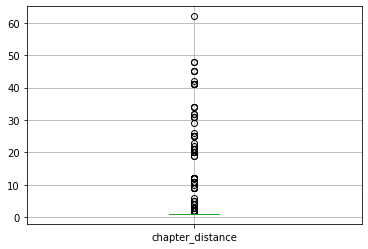

In [66]:
check_uniformity_mapping_file.boxplot(column=['chapter_distance'])

Dựa vào bảng thống kê giá trị và plot trên, ta có thể thấy nếu chọn

In [67]:
check_uniformity_mapping_file[check_uniformity_mapping_file.chapter_distance>20].sample(10)

node_id child_hscode parent_hscode    category_name  \
1623    13830051     96032900          3402  Cleaning & Care   
1077  9057019011     96062200          7113   Buttons & Pins   
1576  2229581011     95059000          6114      Kids & Baby   
1246  2492459011     63079090          4203           Aprons   
843   5427588011     62171090          8308       Suspenders   
1836  2232357011     39173299          8422            Hoses   
246   7454907011     96151900          7117  Brooches & Pins   
1687  2477391011     84238910          4202   Luggage Scales   
1648  3421063011     42029990          6406        Shoe Bags   
326   3478925011     42023200          9004   Eyeglass Cases   

                                          category_tree  child_hscode_format  \
1623  [Clothing, Shoes & Jewelry ,  Novelty, Costume...                    8   
1077  [Clothing, Shoes & Jewelry ,  Novelty, Costume...                    8   
1576  [Clothing, Shoes & Jewelry ,  Novelty, Costume...                    8   
1246  [Clothing, Shoes & Jewelry ,  Novelty, Costume...                    8   
843   [Clothing, Shoes & Jewelry ,  Boys ,  Accessor...                    8   
1836  [Appliances ,  Parts & Accessories ,  Dishwash...                    8   
246   [Clothing, Shoes & Jewelry ,  Women ,  Jewelry...                    8   
1687  [Clothing, Shoes & Jewelry ,  Luggage & Travel...                    8   
1648  [Clothing, Shoes & Jewelry ,  Novelty, Costume...                    8   
326   [Clothing, Shoes & Jewelry ,  Women ,  Accesso...                    8   

      parent_hscode_format  uniformity_check  section_similarity_check  \
1623                     4             False                     False   
1077                     4             False                     False   
1576                     4             False                     False   
1246                     4             False                     False   
843                      4             False                     False   
1836                     4             False                     False   
246                      4             False                     False   
1687                     4             False                     False   
1648                     4             False                     False   
326                      4             False                     False   

      chapter_distance  
1623                62  
1077                25  
1576                34  
1246                21  
843                 21  
1836                45  
246                 25  
1687                42  
1648                22  
326                 48

Nhận định sau khi kiểm tra dữ liệu (kiểm tra bằng cách dò trong biểu mẫu thuế để biết loại hàng, so với category_name): 
- Khi **khoảng cách giữa 2 giá trị đầu (chương) giữa parent và child nhỏ** -> cả hai đều chính xác -> child_hscode có thể chi tiết hơn -> chọn child_hscode: khoảng cách chọn 1 <= x <= 5 
- Khi **khoảng cách giữa 2 giá trị đầu (chương) giữa parent và child lớn ( > 5)** -> parent chính xác, child sai -> chọn parent.

**Lưu ý**: Ở phiên bản dữ liệu sau cần làm thêm bước lựa chọn mã nào có mức thuế thấp hơn.

In [68]:
check_uniformity_mapping_file['final_child_hscode'] = check_uniformity_mapping_file.apply(lambda x: x.child_hscode if x.chapter_distance<5 else x.parent_hscode+'0000' ,axis=1)

/tmp/ipykernel_14920/3882831984.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_uniformity_mapping_file['final_child_hscode'] = check_uniformity_mapping_file.apply(lambda x: x.child_hscode if x.chapter_distance<5 else x.parent_hscode+'0000' ,axis=1)


In [69]:
check_uniformity_mapping_file

node_id child_hscode parent_hscode      category_name  \
14    5418124011     62064000          6109            Henleys   
16       1044548     62064000          6109              Polos   
114      1044646     62021990          6102    Coats & Jackets   
126   2348895011     62021990          6102      Trench & Rain   
127   2348899011     62021990          6102              Vests   
...          ...          ...           ...                ...   
1847  2232339011     85366999          8451   Plug Receptacles   
1848  2232340011     85444949          8451        Power Cords   
1849  9425850011     85169090          8451  Replacement Parts   
1850  2232341011     85169090          8451  Shoe Rack Inserts   
1851  2232342011     39173299          8451              Vents   

                                          category_tree  child_hscode_format  \
14    [Clothing, Shoes & Jewelry ,  Women ,  Clothin...                    8   
16    [Clothing, Shoes & Jewelry ,  Women ,  Clothin...                    8   
114   [Clothing, Shoes & Jewelry ,  Women ,  Clothin...                    8   
126   [Clothing, Shoes & Jewelry ,  Women ,  Clothin...                    8   
127   [Clothing, Shoes & Jewelry ,  Women ,  Clothin...                    8   
...                                                 ...                  ...   
1847  [Appliances ,  Parts & Accessories ,  Dryer Pa...                    8   
1848  [Appliances ,  Parts & Accessories ,  Dryer Pa...                    8   
1849  [Appliances ,  Parts & Accessories ,  Dryer Pa...                    8   
1850  [Appliances ,  Parts & Accessories ,  Dryer Pa...                    8   
1851  [Appliances ,  Parts & Accessories ,  Dryer Pa...                    8   

      parent_hscode_format  uniformity_check  section_similarity_check  \
14                       4             False                     False   
16                       4             False                     False   
114                      4             False                     False   
126                      4             False                     False   
127                      4             False                     False   
...                    ...               ...                       ...   
1847                     4             False                     False   
1848                     4             False                     False   
1849                     4             False                     False   
1850                     4             False                     False   
1851                     4             False                     False   

      chapter_distance final_child_hscode  
14                   1           62064000  
16                   1           62064000  
114                  1           62021990  
126                  1           62021990  
127                  1           62021990  
...                ...                ...  
1847                 1           85366999  
1848                 1           85444949  
1849                 1           85169090  
1850                 1           85169090  
1851                45           84510000  

[442 rows x 11 columns]

Lấy list các index cần sửa:

In [70]:
index_list = check_uniformity_mapping_file.index.tolist()
mapping_file_tmp.loc[index_list]

node_id child_hscode parent_hscode      category_name  \
14    5418124011     62064000          6109            Henleys   
16       1044548     62064000          6109              Polos   
114      1044646     62021990          6102    Coats & Jackets   
126   2348895011     62021990          6102      Trench & Rain   
127   2348899011     62021990          6102              Vests   
...          ...          ...           ...                ...   
1847  2232339011     85366999          8451   Plug Receptacles   
1848  2232340011     85444949          8451        Power Cords   
1849  9425850011     85169090          8451  Replacement Parts   
1850  2232341011     85169090          8451  Shoe Rack Inserts   
1851  2232342011     39173299          8451              Vents   

                                          category_tree  child_hscode_format  \
14    [Clothing, Shoes & Jewelry ,  Women ,  Clothin...                    8   
16    [Clothing, Shoes & Jewelry ,  Women ,  Clothin...                    8   
114   [Clothing, Shoes & Jewelry ,  Women ,  Clothin...                    8   
126   [Clothing, Shoes & Jewelry ,  Women ,  Clothin...                    8   
127   [Clothing, Shoes & Jewelry ,  Women ,  Clothin...                    8   
...                                                 ...                  ...   
1847  [Appliances ,  Parts & Accessories ,  Dryer Pa...                    8   
1848  [Appliances ,  Parts & Accessories ,  Dryer Pa...                    8   
1849  [Appliances ,  Parts & Accessories ,  Dryer Pa...                    8   
1850  [Appliances ,  Parts & Accessories ,  Dryer Pa...                    8   
1851  [Appliances ,  Parts & Accessories ,  Dryer Pa...                    8   

      parent_hscode_format  uniformity_check  section_similarity_check  
14                       4             False                     False  
16                       4             False                     False  
114                      4             False                     False  
126                      4             False                     False  
127                      4             False                     False  
...                    ...               ...                       ...  
1847                     4             False                     False  
1848                     4             False                     False  
1849                     4             False                     False  
1850                     4             False                     False  
1851                     4             False                     False  

[442 rows x 9 columns]

Gán cho từng index:

In [71]:
for m_index in index_list:
    mapping_file_tmp.at[m_index,'child_hscode'] =  check_uniformity_mapping_file.loc[m_index].final_child_hscode

In [72]:
mapping_file_tmp.loc[index_list]

node_id child_hscode parent_hscode      category_name  \
14    5418124011     62064000          6109            Henleys   
16       1044548     62064000          6109              Polos   
114      1044646     62021990          6102    Coats & Jackets   
126   2348895011     62021990          6102      Trench & Rain   
127   2348899011     62021990          6102              Vests   
...          ...          ...           ...                ...   
1847  2232339011     85366999          8451   Plug Receptacles   
1848  2232340011     85444949          8451        Power Cords   
1849  9425850011     85169090          8451  Replacement Parts   
1850  2232341011     85169090          8451  Shoe Rack Inserts   
1851  2232342011     84510000          8451              Vents   

                                          category_tree  child_hscode_format  \
14    [Clothing, Shoes & Jewelry ,  Women ,  Clothin...                    8   
16    [Clothing, Shoes & Jewelry ,  Women ,  Clothin...                    8   
114   [Clothing, Shoes & Jewelry ,  Women ,  Clothin...                    8   
126   [Clothing, Shoes & Jewelry ,  Women ,  Clothin...                    8   
127   [Clothing, Shoes & Jewelry ,  Women ,  Clothin...                    8   
...                                                 ...                  ...   
1847  [Appliances ,  Parts & Accessories ,  Dryer Pa...                    8   
1848  [Appliances ,  Parts & Accessories ,  Dryer Pa...                    8   
1849  [Appliances ,  Parts & Accessories ,  Dryer Pa...                    8   
1850  [Appliances ,  Parts & Accessories ,  Dryer Pa...                    8   
1851  [Appliances ,  Parts & Accessories ,  Dryer Pa...                    8   

      parent_hscode_format  uniformity_check  section_similarity_check  
14                       4             False                     False  
16                       4             False                     False  
114                      4             False                     False  
126                      4             False                     False  
127                      4             False                     False  
...                    ...               ...                       ...  
1847                     4             False                     False  
1848                     4             False                     False  
1849                     4             False                     False  
1850                     4             False                     False  
1851                     4             False                     False  

[442 rows x 9 columns]

## 2.2 Join dữ liệu

Join 2 file lại: 
>1. Join dataframe dựa trên trường node_id
>2. Ở file 1 lấy các trường: sku, name, node_id, node_name
>3. Ở file 2 lấy các trường: node_id, child_hscode, parent_hscode, category_name, category_tree

Câu hỏi đặt ra:
1. Khi join file có bao nhiêu dữ liệu trống?
2. Tìm phân phối của dữ liệu sau khi join:
> 2.1. Nên xem phân phối của giá trị nào? child_hscode, parent_hscode hay node_id?<br/>
> 2.2. Mối quan hệ giữa child_hscode, parent_hscode và node_id là gì? 1-nhiều (ví dụ 1 child_hscode có nhiều node_id), 1-1, nhiều-1 hay nhiều-nhiều? <br/>
> 2.3. Dựa trên mối quan hệ và phân phối, nên crawl dữ liệu thiếu theo giá trị nào?

In [73]:
len(sample_df)

19078440

In [74]:
final_mapping_file = mapping_file_tmp[['node_id','child_hscode','parent_hscode','category_name','category_tree']]
final_df  = sample_df[['sku','name','node_id','node_name']]

In [75]:
df = final_df.merge(final_mapping_file, how='outer', on='node_id')

In [76]:
len(df)

26750003

Sau khi merge dữ liệu, ta cần kiểm tra xem có bao nhiêu dữ liệu thiếu:
1. **Dữ liệu thiếu từ file mapping**: không có hscode tương ứng cho node_id trong file Amazon
2. **Dữ liệu thiếu từ file Amazon**: không có node_id tương ứng cho hscode trong file mapping

Tạm thời không quan tâm đến trường hợp 1, do việc bổ sung thêm hscode sẽ tốn thời gian và chưa cần thiết. Hướng xử lý dữ liệu thiếu từ Amazon:
1. Thống kê node_id, parent_hscode, child_hscode thiếu.
2. Dựa trên đó để đánh giá thông tin cần bổ sung thêm (có cần crawl thêm dữ liệu không? nếu crawl thì theo tiêu chí nào?)

In [77]:
# def missing_percentage(c):
#     return (c.isna().mean() * 100).round(1)
# def median(c):
#     return c.quantile(0.5).round(1)
# def num_values(df):
#     return df.nunique()
# def value_percentages(c):
#     return dict((c.value_counts(normalize=True) * 100).round(1))
# df.agg([missing_percentage, num_values, value_percentages])

**Chú ý** do merge theo kiểu 'outer' và do tính chất của mỗi df:
1. **sku, name và node_name** khi null sẽ cùng null
2. **child_hscode, parent_hscode, category_name, category_tree** khi null sẽ cùng null

In [78]:
df[(df.sku.isnull()==True)]

sku name     node_id node_name child_hscode parent_hscode  \
26734848  NaN  NaN  2346730011       NaN     61044900          6104   
26734849  NaN  NaN  2346729011       NaN     61044900          6104   
26734850  NaN  NaN  2969486011       NaN     61044900          6104   
26734851  NaN  NaN  2969490011       NaN     61044900          6104   
26734852  NaN  NaN  2969491011       NaN     61044900          6104   
...       ...  ...         ...       ...          ...           ...   
26749998  NaN  NaN  5499882011       NaN     84716090          8471   
26749999  NaN  NaN  5499841011       NaN     39269099          3926   
26750000  NaN  NaN  9865598011       NaN     39199090          3919   
26750001  NaN  NaN  5499865011       NaN     39199090          3919   
26750002  NaN  NaN  1243737011       NaN     39269099          3926   

                                         category_name  \
26734848                              Special Occasion   
26734849                          Night Out & Cocktail   
26734850                                       Wedding   
26734851                   Mother of the Bride Dresses   
26734852                            Bridesmaid Dresses   
...                                                ...   
26749998  Kindle Fire HDX (3rd Generation) Accessories   
26749999                                        Covers   
26750000                             Screen Protectors   
26750001                             Screen Protectors   
26750002                                   Fetish Wear   

                                              category_tree  
26734848  [Clothing, Shoes & Jewelry ,  Women ,  Clothin...  
26734849  [Clothing, Shoes & Jewelry ,  Women ,  Clothin...  
26734850  [Clothing, Shoes & Jewelry ,  Women ,  Clothin...  
26734851  [Clothing, Shoes & Jewelry ,  Women ,  Clothin...  
26734852  [Clothing, Shoes & Jewelry ,  Women ,  Clothin...  
...                                                     ...  
26749998  [Kindle Store ,  Amazon Device Accessories ,  ...  
26749999  [Kindle Store ,  Amazon Device Accessories ,  ...  
26750000  [Kindle Store ,  Amazon Device Accessories ,  ...  
26750001  [Kindle Store ,  Amazon Device Accessories ,  ...  
26750002  [Health & Household ,  Sexual Wellness ,  Feti...  

[15155 rows x 8 columns]

Kiểm tra những child_hscode và parent_hscode bị thiếu thuộc node_name nào:

In [79]:
df[df.child_hscode.isnull()==True].node_name.sample(20)

23387648                          Tunnels
24379794                           Bezels
8991266                          Costumes
15066963                Adult Alternative
8991144                          Costumes
7955819                    Casual Jackets
22509130                       Rice Flour
12787275    Stuffed Animals & Teddy Bears
19977412            Food Jars & Canisters
14818446                         Mid-Calf
24084597                         Footwear
7015232              Patio, Lawn & Garden
26018270               Backpacking Stoves
11760526                           Chukka
17001981                             Pots
7769769                             Flats
11370204                   Heeled Sandals
14159704           Plush Interactive Toys
11039566                       Flip-Flops
8990403                          Costumes
Name: node_name, dtype: object

Kiểm tra những 'name' bị thiếu thuộc category_name nào:

In [80]:
df[df.name.isnull()==True].category_name.sample(20)

26738079    Nonprofit Organizations & Charities
26744663                        Mashed Potatoes
26740779                             Meditation
26749590                                 Boxing
26744887                                 Grains
26746404                              Food Jars
26746898                            Prophy Cups
26743738                                General
26748947                               Earrings
26740728                                    Gay
26736724                   Secondary Diaphragms
26744561                          Peanut-Butter
26742801                            Coral Reefs
26743319                                   Cuba
26737779                                   Folk
26734849                   Night Out & Cocktail
26735232           Sweat Headbands & Wristbands
26739012                            Bible Study
26742361                                   Gaia
26735099                            Track Pants
Name: category_name, dtype: object

Như đã nhắc ở trên, chỉ có thể bổ sung dữ liệu trong trường hợp có 1 parent_hscode, child_hscode và node_id, nhưng thiếu sản phẩm cho parent_hscode/node_id/child_hscode đó. Vậy phần tiếp theo là thực hiện thống kê để tìm những tiêu chí để crawl dữ liệu, tuy nhiên, dữ liệu hiện tại vẫn chưa đủ sạch nên cần phải xử lý thêm trước khi thực hiện thống kê, nên ta sẽ qua phần 2.3 trước.

Trước khi qua 2.3 sẽ dropna

In [81]:
df = df.dropna(subset=['parent_hscode','name'])

## 2.3 Xử lý dữ liệu sau khi join

1. Thống kê dữ liệu:
>* Kiểm tra loại quan hệ giữa các trường dữ liệu cần xử lý, gồm: node_id, child_hscode, name, sku.
>>* Kiểm tra xem giữa chúng là quan hệ 1-1, 1-N, N-N hay N-1
1. Xử lý dữ liệu ở trường name:
>*   length <= 2 kí tự: xóa
>*   2 < length <= 3, 4, 5 kí tự: chỉ giữ vật phẩm thuộc **nhóm sách, công nghệ, movie, game**
2. Xử lý dữ liệu trùng lặp theo 6 trường hợp:
>*   Trường hợp 1: Trùng name, trùng node_id, trùng sku
>*   Trường hợp 2: Khác name, trùng node_id, trùng sku
>*   Trường hợp 3: Trùng name, trùng sku, khác node_id
>*   Trường hợp 4: Khác name, trùng sku, khác node_id (đã xử lý ở trường hợp 2+3)
>*   Trường hợp 5: Trùng name, khác sku, trùng node_id
>*   Trường hợp 6: Trùng name, khác sku, khác node_id
3. Gom dữ liệu thành các nhóm dựa trên phân tích thống kê của trường children_hscode

### 2.3.1 Kiểm tra tính quan hệ giữa dữ liệu

#### Kiểm tra loại quan hệ của các trường bên mapping_file

Tại sao phải kiểm tra loại quan hệ của các trường mapping_file?

Trong các trường của mapping_file, có 2 trường cần kiểm tra quan hệ là **node_id và child_hscode**, vì nếu 1 node_id có nhiều child_hscode (1-N), tức là một sản phẩm có thể được phân vào nhiều loại child_hscode khác nhau --> cần kiểm tra xem cần giữ hay bỏ, nếu giữ thì giữ mã nào và bỏ mã nào? <br/>
**Ngược lại**, nếu 1 child_hscode có nhiều node_id thì khi bổ sung dữ liệu thiếu (hiện tại đang crawl dữ liệu theo node_id) thì sẽ phân nó vào child_hscode nào?

In [82]:
df.node_id.nunique()

16978

In [83]:
df.child_hscode.nunique()

1963

Dựa trên số lượng của node_id và child_hscode, mối quan hệ của giữa child_hscode và node_id tạm là 1-N. Giờ cần kiểm tra ngược lại, một node_id có thể có nhiều child_hscode hay không? Nếu có thì quan hệ giữa chúng là N-N.

Kiểm tra bằng cách tìm nunique của child_hscode có node_id là 5 giá trị đầu của value count (5 giá trị xuất hiện nhiều nhất trong trường node_id) 

In [84]:
df.node_id.value_counts()

3081461011     657921
10971181011    233256
6358540011     203806
9056987011     149222
6358544011     145416
                ...  
8297415011          1
10983781            1
405373011           1
3307775011          1
3777001             1
Name: node_id, Length: 16978, dtype: int64

In [85]:
df[df.node_id==df.node_id.value_counts().index[0]].child_hscode.nunique()

2

In [86]:
df[df.node_id==df.node_id.value_counts().index[1]].child_hscode.nunique()

1

In [87]:
df[df.node_id==df.node_id.value_counts().index[2]].child_hscode.nunique()

2

In [88]:
df[df.node_id==df.node_id.value_counts().index[3]].child_hscode.nunique()

1

In [89]:
df[df.node_id==df.node_id.value_counts().index[4]].child_hscode.nunique()

1

Như vậy mối quan hệ của node_id và child_hscode là N-N.

#### Kiểm tra quan hệ của các trường file Amazon

Tại sao phải kiểm tra quan hệ của các trường file Amazon

Như đã nhắc tới ở phần 2.1.1, trong các trường của df Amazon thì 3 trường cần xử lý chính là **node_id, name và sku** cả 3 trường này đều không có tính unique do vậy có thể trùng lặp với nhau, gây ra hiện tượng đa quan hệ (1-N, 1-1, N-N, N-1), trong đó quan trọng nhất là 2 trường **name** và **node_id** vì chúng liên quan trực tiếp đến kết quả mô hình (name là input còn node id là cầu nối để tìm child_hscode), **sku** đóng vai trò hỗ trợ cung cấp thêm thông tin (vì mỗi sản phẩm thông thường chỉ có một mã sku duy nhất). <br/>
Nếu xảy ra trường hợp đa quan hệ ở đây, ví dụ như 1 tên sản phẩm có nhiều node_id (**là trường hợp 3 ở trên**) thì mô hình sẽ bị nhiễu, huấn luyện không tốt. <br/>
**Ngược lại**, nếu trùng node_id và sku nhưng lại có nhiều tên khác nhau (**là trường hợp 2 ở trên**) thì mô hình cũng sẽ không hiệu quả, vì từ một node_id sẽ có thể có nhiều child_hscode là nhiều nhãn khác nhau. Nếu khác sku thì chúng có thể xem là 2 vật phẩm riêng biệt nhưng chúng lại trùng sku --> cùng 1 sản phẩm mà khác tên + khác node_id --> cần kiểm tra và xử lý. <br/>
Đây là 2 trường hợp tiêu biểu, các trường hợp còn lại sẽ được mô tả chi tiết bên dưới.

In [90]:
df.node_id.nunique()

16978

In [91]:
df.name.nunique()

11269464

In [92]:
df.sku.nunique()

13912814

### 2.3.2 Xử lý dữ liệu ở trường hợp name

Để có thể giữ các vật phẩm thuộc nhóm sách, công nghệ, movie, game, ta cần kiểm tra danh mục của chúng bằng cách sử dụng **category_tree**.

In [93]:
df.category_tree

169         [Grocery & Gourmet Food ,  Cooking & Baking , ...
170         [Grocery & Gourmet Food ,  Cooking & Baking , ...
171         [Grocery & Gourmet Food ,  Cooking & Baking , ...
172         [Grocery & Gourmet Food ,  Cooking & Baking , ...
173         [Grocery & Gourmet Food ,  Cooking & Baking , ...
                                  ...                        
26734839    [Electronics ,  Camera & Photo ,  Binoculars &...
26734840    [Sports & Outdoors ,  Hunting & Fishing ,  Hun...
26734841    [Sports & Outdoors ,  Hunting & Fishing ,  Tac...
26734842       [Software ,  Education & Reference ,  History]
26734843    [Health & Personal Care ,  Medical Supplies & ...
Name: category_tree, Length: 24232519, dtype: object

Vì cấu trúc theo kiểu cây phân loại, nên node đầu tiên (root node) sẽ mang thông tin tổng quát nhất, do đó ta cần loại/giữ thông tin từ node này.

In [94]:
check_category =[tree[0].split(",")[0].strip() for tree in df.category_tree]

In [95]:
set(check_category)

{'Appliances',
 'Arts',
 'Automotive',
 'Baby Products',
 'Beauty',
 'Beauty & Personal Care',
 'Books',
 'Car & Vehicle Electronics',
 'Cell Phones & Accessories',
 'Clothing',
 'Collectibles & Fine Art',
 'Electronics',
 'Grocery & Gourmet Food',
 'Handmade Products',
 'Health & Household',
 'Health & Personal Care',
 'Hobbies',
 'Home & Kitchen',
 'Industrial & Scientific',
 'Kindle Store',
 'Kitchen & Dining',
 'Lights & Lighting Accessories',
 'Motorcycle & Powersports',
 'Musical Instruments',
 'Office Products',
 'Outdoor Recreation',
 'Patio',
 'Pet Supplies',
 'Power & Hand Tools',
 'Small Appliance Parts & Accessories',
 'Software',
 'Sports & Fitness',
 'Sports & Outdoors',
 'Tools & Home Improvement',
 'Toys & Games',
 'Video Games',
 'Watches'}

Từ danh sách danh mục sản phẩm trên, ta cần chọn loại danh mục có thể là thuộc vào 4 loại (sách, âm nhạc, công nghệ, phim ảnh) trên.

In [96]:
category_rule = ['Books','CDs','Toys','Video','Cell','Electronics','Movies','Software']

**Chú ý**: phương pháp làm này sẽ thủ công và không chính xác hoàn toàn cho có thể có những nhánh danh mục con thuộc các lọa danh mục khác có các sản phẩm thuộc 4 loại: sách, âm nhạc, công nghệ, phim ảnh

In [97]:
filtered_category = [cate for cate in list(set(check_category)) if cate.split(" ")[0] in category_rule]

In [98]:
filtered_category

['Video Games',
 'Software',
 'Books',
 'Cell Phones & Accessories',
 'Electronics',
 'Toys & Games']

Sau khi đã lọc được danh mục cần thiết, tiến hành lựa chọn theo phân tích:
1. Xử lý dữ liệu ở trường name:
>*   length <= 2 kí tự: xóa
>*   2 < length <= 3, 4, 5 kí tự: chỉ giữ vật phẩm thuộc **nhóm sách, công nghệ, movie, game**

In [99]:
df['name_len'] = df.name.apply(lambda x: len(x)) #lấy độ dài của tên
df['check_cate'] = df.category_tree.apply(lambda x: True if x[0].split(",")[0].strip() in filtered_category else False) #kiểm tra cate

In [100]:
df[df.name_len<=2].index

Int64Index([   52854,    52855,   301545,   551292,   555537,   559212,
              568477,   651131,   653559,   659662,
            ...
            26446009, 26446010, 26446011, 26446015, 26446070, 26446197,
            26532442, 26585398, 26648874, 26730209],
           dtype='int64', length=785)

In [101]:
df = df.drop(df[df.name_len<=2].index)
df = df.drop((df[df.check_cate==False].index) & (df[(df.name_len>=3) & (df.name_len>=5)].index))

/tmp/ipykernel_14920/4081153870.py:2: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  df = df.drop((df[df.check_cate==False].index) & (df[(df.name_len>=3) & (df.name_len>=5)].index))


Bỏ 2 trường name_len và check_cate vì đã xử lý xong:

In [102]:
df.columns

Index(['sku', 'name', 'node_id', 'node_name', 'child_hscode', 'parent_hscode',
       'category_name', 'category_tree', 'name_len', 'check_cate'],
      dtype='object')

In [103]:
df = df[['sku', 'name', 'node_id', 'node_name', 'child_hscode', 'parent_hscode',
       'category_name', 'category_tree']]

### Case 1: trùng sku, trùng name, trùng node_id

Xử lý vì dữ liệu trùng hoàn toàn

In [104]:
df

sku                                               name  \
32182     B013PWQN1Y  Amazon Basics 4K Mini DisplayPort to DisplayPo...   
32183     B013PWQN1Y  Amazon Basics 4K Mini DisplayPort to DisplayPo...   
32184     B01J8S6X2I  Amazon Basics DisplayPort to DisplayPort 1.2 C...   
32185     B01J8S6X2I  Amazon Basics DisplayPort to DisplayPort 1.2 C...   
32186     B000068OES  Hosa DBK-303 TDIF Dubbing Cable, DB25 to Same,...   
...              ...                                                ...   
26734824  B08BG51ZFY  UL Listed 8ft 2 prong Power Cord Replacement f...   
26734825  B00F2Y1CH4  DreamGEAR DGXB1-6603 Dual Charge Dock Black fo...   
26734826  B003D7JVB6  Melissa & Doug Children's Book - Poke-a-Dot: 1...   
26734839  B00BD53BWU                             Nikon ACULON A30 10X25   
26734842  B0000CFXR3            Great Battles of the Civil War Animated   

             node_id             node_name child_hscode parent_hscode  \
32182         464418          Video Cables     85442011          8544   
32183         464418          Video Cables     85442011          8544   
32184         464418          Video Cables     85442011          8544   
32185         464418          Video Cables     85442011          8544   
32186         464418          Video Cables     85442011          8544   
...              ...                   ...          ...           ...   
26734824    10993991          Commodore 64     95045000          9504   
26734825  6469272011  Batteries & Chargers     95049099          9504   
26734826  9432906011        Nursery Rhymes     49030000          4903   
26734839      297842            Binoculars     90051000          9005   
26734842      229568               History     84717020          8471   

                 category_name  \
32182             Video Cables   
32183             Video Cables   
32184             Video Cables   
32185             Video Cables   
32186             Video Cables   
...                        ...   
26734824          Commodore 64   
26734825  Batteries & Chargers   
26734826        Nursery Rhymes   
26734839            Binoculars   
26734842               History   

                                              category_tree  
32182     [Electronics ,  Accessories & Supplies ,  Audi...  
32183     [Electronics ,  Accessories & Supplies ,  Cabl...  
32184     [Electronics ,  Accessories & Supplies ,  Audi...  
32185     [Electronics ,  Accessories & Supplies ,  Cabl...  
32186     [Electronics ,  Accessories & Supplies ,  Audi...  
...                                                     ...  
26734824  [Video Games ,  Retro Gaming & Microconsoles ,...  
26734825  [Video Games ,  Xbox One ,  Accessories ,  Bat...  
26734826  [Books ,  Children's Books ,  Literature & Fic...  
26734839  [Electronics ,  Camera & Photo ,  Binoculars &...  
26734842     [Software ,  Education & Reference ,  History]  

[5948069 rows x 8 columns]

In [105]:
def case_1(df):
    #input: df
    #output: df dropped: trùng sku, trùng name, trùng node_id
    filtered_index = df.drop_duplicates(subset=['sku','name','node_id']).index
    duplicated_index = set(df.index) - set(filtered_index) 
    return filtered_index, duplicated_index
case_1_final_index, case_1_deleted_index = case_1(df)

In [106]:
case_1_processed_df = df.loc[case_1_final_index]

In [107]:
case_1_deleted_df = df.loc[case_1_deleted_index]

/tmp/ipykernel_14920/2234404504.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  case_1_deleted_df = df.loc[case_1_deleted_index]


In [108]:
case_1_deleted_df

sku                                               name  \
6669514   B07G9JXCCC  AGVEE S21 S20 Dual USB-C Headphones & Charging...   
6669518   B07FRWK4DP  Washinglee USB Programming Cable for Allen Bra...   
6669523   B07FQDZLC3  USB Type C Console Cable, USB Type A Console C...   
6669524   B07FQDZLC3  USB Type C Console Cable, USB Type A Console C...   
6669526   B07FQDZLC3  USB Type C Console Cable, USB Type A Console C...   
...              ...                                                ...   
16770033  B097T8JDR9  Portable Neck Fan,HIFFUN-1 USB Rechargeable Ha...   
16770035  B08XLSWK83  Meonum 2 Pieces Small Personal Handheld Fan Po...   
16770037  B08X2QCP11  COOLREALL Portable Mini Fan, USB Fans, 2000mAh...   
16770039  B0912RNC39  Neck Fan Portable,Personal USB Mini Hands Free...   
25165339  B00068OSNQ               Jeep Garage Park Stop Light (JX-PRK)   

             node_id              node_name child_hscode parent_hscode  \
6669514       464394             USB Cables     85442011          8544   
6669518       464394             USB Cables     85442011          8544   
6669523       464394             USB Cables     85442011          8544   
6669524       464394             USB Cables     85442011          8544   
6669526       464394             USB Cables     85444911          8544   
...              ...                    ...          ...           ...   
16770033  3015416011               USB Fans     84145999          8414   
16770035  3015416011               USB Fans     84145999          8414   
16770037  3015416011               USB Fans     84145999          8414   
16770039  3015416011               USB Fans     84145999          8414   
25165339     3008971  Car Safety & Security     85318090          8531   

                  category_name  \
6669514              USB Cables   
6669518              USB Cables   
6669523              USB Cables   
6669524              USB Cables   
6669526              USB Cables   
...                         ...   
16770033               USB Fans   
16770035               USB Fans   
16770037               USB Fans   
16770039               USB Fans   
25165339  Car Safety & Security   

                                              category_tree  
6669514   [Electronics ,  Computers & Accessories ,  Cab...  
6669518   [Electronics ,  Accessories & Supplies ,  Comp...  
6669523   [Electronics ,  Accessories & Supplies ,  Comp...  
6669524   [Electronics ,  Computers & Accessories ,  Cab...  
6669526   [Electronics ,  Computers & Accessories ,  Com...  
...                                                     ...  
16770033  [Electronics ,  Computers & Accessories ,  Cab...  
16770035  [Electronics ,  Computers & Accessories ,  Cab...  
16770037  [Electronics ,  Computers & Accessories ,  Cab...  
16770039  [Electronics ,  Computers & Accessories ,  Cab...  
25165339  [Electronics ,  Car & Vehicle Electronics ,  C...  

[2848592 rows x 8 columns]

### Case 2: trùng sku, khác name, trùng node_id

Tại sao phải xử lý trường hợp này? Vì khi **trùng sku và node_id** thì 2 vật phẩm này có khả năng rất cao **là 1**, nhưng nó lại khác giá trị 'name' - là khác tên vật phẩm, nếu không xử lý case này thì có khả năng model học sẽ bị ảnh hưởng bởi có nhiều mẫu dữ liệu dư thừa hoặc sai. 

Các bước thức hiện case 2:
1. Gom nhóm: gom theo trùng sku_node và node_id trước -> gom theo name sau
2. Vectorize câu
3. Tính similarity cho các bản nhúng cho câu (so sánh với tên xuất hiện đầu tiên)

In [109]:
case_2_df = case_1_processed_df

In [110]:
case_2_df

sku                                               name  \
32182     B013PWQN1Y  Amazon Basics 4K Mini DisplayPort to DisplayPo...   
32184     B01J8S6X2I  Amazon Basics DisplayPort to DisplayPort 1.2 C...   
32186     B000068OES  Hosa DBK-303 TDIF Dubbing Cable, DB25 to Same,...   
32188     B0000C5FNN  Belkin Omniview SOHO KVM Cable USB DVI and Aud...   
32190     B000246RLA     Acoustic Research DA-091 Component Video Cable   
...              ...                                                ...   
26734823  B08BG51ZFY  UL Listed 8ft 2 prong Power Cord Replacement f...   
26734825  B00F2Y1CH4  DreamGEAR DGXB1-6603 Dual Charge Dock Black fo...   
26734826  B003D7JVB6  Melissa & Doug Children's Book - Poke-a-Dot: 1...   
26734839  B00BD53BWU                             Nikon ACULON A30 10X25   
26734842  B0000CFXR3            Great Battles of the Civil War Animated   

             node_id             node_name child_hscode parent_hscode  \
32182         464418          Video Cables     85442011          8544   
32184         464418          Video Cables     85442011          8544   
32186         464418          Video Cables     85442011          8544   
32188         464418          Video Cables     85442011          8544   
32190         464418          Video Cables     85442011          8544   
...              ...                   ...          ...           ...   
26734823    10993991          Commodore 64     95049099          9504   
26734825  6469272011  Batteries & Chargers     95049099          9504   
26734826  9432906011        Nursery Rhymes     49030000          4903   
26734839      297842            Binoculars     90051000          9005   
26734842      229568               History     84717020          8471   

                 category_name  \
32182             Video Cables   
32184             Video Cables   
32186             Video Cables   
32188             Video Cables   
32190             Video Cables   
...                        ...   
26734823          Commodore 64   
26734825  Batteries & Chargers   
26734826        Nursery Rhymes   
26734839            Binoculars   
26734842               History   

                                              category_tree  
32182     [Electronics ,  Accessories & Supplies ,  Audi...  
32184     [Electronics ,  Accessories & Supplies ,  Audi...  
32186     [Electronics ,  Accessories & Supplies ,  Audi...  
32188     [Electronics ,  Accessories & Supplies ,  Audi...  
32190     [Electronics ,  Accessories & Supplies ,  Audi...  
...                                                     ...  
26734823      [Video Games ,  More Systems ,  Commodore 64]  
26734825  [Video Games ,  Xbox One ,  Accessories ,  Bat...  
26734826  [Books ,  Children's Books ,  Literature & Fic...  
26734839  [Electronics ,  Camera & Photo ,  Binoculars &...  
26734842     [Software ,  Education & Reference ,  History]  

[3099477 rows x 8 columns]

Bắt đầu gom nhóm theo **sku và node_id** để xử lý:

In [111]:
case_2_processing_df = case_2_df.copy()

In [112]:
case_2_processing_df['sku_node_id_duplicated']=case_2_processing_df.duplicated(subset=['sku','node_id'],keep=False)

In [113]:
case_2_processing_df = case_2_processing_df[case_2_processing_df.sku_node_id_duplicated==True]

Vì trùng sku và node_id nhưng khác **name**, nên đối với giá trị trong trường name cũng phải kiểm tra xem chúng có độ tương đồng cao hay không, vì chỉ nên xóa nếu quá **giống** ngược lại nếu có độ khác nhất định thì nên giữ lại để làm giàu dữ liệu. Cần phải tải một số package/library:

In [114]:
#!pip install -U sentence-transformers

In [115]:
#!pip install gensim

In [116]:
#!pip3 install ipywidgets --user

In [117]:
#!pip install h5py

In [118]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

2022-06-29 03:26:44.063363: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-29 03:26:44.063423: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [119]:
from tqdm import tqdm, tqdm_pandas
import pandas as pd
tqdm.pandas()

Tính vector từ bằng mô hình **SentenceTransformer**

In [120]:
# case_2_df_processing['tensor']=case_2_df_processing.name.progress_apply(lambda x: model.encode(x, convert_to_tensor=True))

Cũng là tính vector bằng mô hình **SentenceTransformer** nhưng dùng **multiprocessing**

In [121]:
def function_vectorize(name,model):
    return name, model.encode(name, convert_to_tensor=True)
def async_extract_features_case_2(function, name_list, model):
    import concurrent.futures
    import urllib.request
    import os
    max_procesas = os.cpu_count()
    executor = concurrent.futures.ThreadPoolExecutor(max_workers=max_process)
    futures = []
    for name in name_list:
        try:       
            futures.append(executor.submit(function, name, model=model))        
        except Exception as e:
            print(e)
    data = {}
    for future in concurrent.futures.as_completed(futures):
        item = future.result()
        if len(item) == 2:
            data[item[0]] = item[1]
        else:
            print('error')

    return data

In [122]:
#%%time
#tensor_dict = async_extract_features_case_2(function_vectorize, case_2_processing_df.name.tolist(),model)

Sau khi tính xong thì save lại để lưu trữ:

In [123]:
# import pickle
# with open('saved_dictionary.pkl', 'wb') as f:
#     pickle.dump(tensor_dict, f)
# #with open('saved_dictionary.pkl', 'rb') as f:
# #    loaded_dict = pickle.load(f)

Hoặc load pickle (đã có sẵn) thành dictionary, **chú ý** vì minh họa nên chỉ xử lý 100.000 dòng, còn file chứa tensor của tất cả các tên (đã được xử lý tới case 1) nằm ở đường dẫn sau trên server 145: **/data_science/data_science/data/v1/hs_code_vinh/full_saved_dictionary.pkl** 

In [ ]:
import pickle
with open('/data_science/data_science/data/v1/hs_code_vinh/full_saved_dictionary.pkl', 'rb') as handle:
    tensor_dict = pickle.load(handle)

Gán tensor cho name tương ứng:

In [ ]:
case_2_processing_df['name_tensor'] = case_2_processing_df.name.apply(lambda x: tensor_dict[x])

In [205]:
# quan sát dữ liệu lần nữa
case_2_processing_df.sample(2)

sku                               name node_id  \
7871786  1538761343  The Fallen (Memory Man Series, 4)  720360   
661719   1851779035        Balenciaga: Shaping Fashion    1829   

                  node_name child_hscode parent_hscode       category_name  \
7871786  Action & Adventure     49019910          4901  Action & Adventure   
661719       Graphic Design     49019990          4901      Graphic Design   

                                             category_tree  \
7871786  [Books ,  Literature & Fiction ,  Genre Fictio...   
661719     [Books ,  Arts & Photography ,  Graphic Design]   

         sku_node_id_duplicated  \
7871786                    True   
661719                     True   

                                               name_tensor  similarity  
7871786  [tensor(-0.0110), tensor(-0.0338), tensor(-0.0...    1.000000  
661719   [tensor(-0.0214), tensor(0.0571), tensor(0.027...    0.762171

In [ ]:
case_2_processing_df['sku_node_id_duplicated']=case_2_processing_df.duplicated(subset=['sku','node_id'],keep=False)

In [ ]:
case_2_df_processing = case_2_processing_df[case_2_processing_df.sku_node_id_duplicated==True].copy()

Sau khi gom nhóm theo **sku và node_id** thì xử lý theo **name**:

In [ ]:
case_2_grouped_df = case_2_processing_df.groupby(by=['sku','node_id'])
groups = list(case_2_grouped_df.groups.keys())

Quan sát số lượng phần tử của mỗi group.

In [ ]:
case_2_grouped_df.size()

Lấy index của từng group.

In [ ]:
list_index = []
for key in range(len(groups)):
    list_index.append(case_2_grouped_df.get_group(groups[key]).index)

Tính similarity cho từng cặp name. **Chú ý** rằng đoạn code sau chỉ duyệt 1 lần cho mỗi group, ví dụ group có 3 phần từ A, B, C $\rightarrow$ tính cho (A, A), (A, B), (A, C). Trong đó mặc định similar(A, A) = 0.

In [ ]:
similarity_dict={}
for a_list in list_index:
    first_row = a_list[0]
    for a_index in a_list:
        if a_index == first_row:
            similarity_dict[a_index]=-1
        else:
            similarity_dict[a_index]= util.pytorch_cos_sim(case_2_processing_df.loc[first_row].name_tensor, case_2_processing_df.loc[a_index].name_tensor)

In [ ]:
similarity_dict

Gán giá trị cho cột mới.

In [ ]:
case_2_processing_df['similarity'] = [similarity_dict[x] for x in case_2_processing_df.index.values]

In [206]:
case_2_processing_df.similarity.describe()

count    33541.000000
mean         0.450321
std          0.458016
min         -0.029113
25%          0.000000
50%          0.237495
75%          0.948647
max          1.000001
Name: similarity, dtype: float64

Lấy threshold (có thể là mean, median,...). Ở đây là median.

In [ ]:
case_2_processing_df.similarity = case_2_processing_df.similarity.apply(lambda x: float(x)) 

In [ ]:
case_2_processing_df.similarity.describe()

In [ ]:
case_2_processing_df.boxplot(column='similarity')

In [ ]:
case_2_median_threshold = case_2_processing_df.similarity.describe()['50%']

In [ ]:
case_2_deleted_df = case_2_processing_df[case_2_processing_df.similarity > case_2_median_threshold]

In [ ]:
case_2_processed_df = case_2_df.drop(case_2_deleted_df.index)

### Case 3: Trùng name, trùng sku, khác node_id

Trường hợp này sẽ tạo ra các vấn đề sau:
1. Cùng 1 sản phẩm (cùng name, cùng sku) lại được phân vào các loại danh mục khác nhau (khác node_id) $\rightarrow$ làm dữ liệu bị sai.
2. Khác node_id còn dẫn tới việc khác child_hscode, như vậy từ một input đầu vào (trùng name), lại có thể có nhiều output khác nhau (khác hscode)

Hướng xử lý:
1. Group theo name và sku.
2. Sau khi quan sát, có thể thấy một sản phẩm được chia ra làm 2 node_id nằm 

In [212]:
case_3_df = case_2_processed_df

In [213]:
len(case_3_df)

3082707

Bắt đầu gom nhóm theo **name và sku** để xử lý:

In [214]:
case_3_df['name_sku_duplicated']=case_3_df.duplicated(subset=['sku','name'],keep=False)

In [215]:
case_3_processing_df = case_3_df.copy()

In [216]:
case_3_processing_df = case_3_processing_df[case_3_processing_df.name_sku_duplicated==True]

In [217]:
case_3_processing_df

sku                                               name  \
32718     B07ZCJDY16  DisplayPort to DP 4K 60Hz 3 Feet Cable, Benfei...   
32728     B002NV0NSS  Monoprice Commercial Extension 15ft 24AWG CL2 ...   
32758     B07GGVJDQR  DisplayPort to DP 4K 60Hz 10 Feet Cable, Benfe...   
32760     B010W1SJ2C  Lifesize Link Cable - 4M (Phone, 2ND GEN 1000-...   
260112    B08BFY4RP2  Sony Xperia 1 II XQ-AT52 5G 256GB 8GB RAM Inte...   
...              ...                                                ...   
26733461  B07ZPDJB5J          Kenwood KMM-BT328U Digital Media Receiver   
26734633  B01G3WBH9G  ASTRO Gaming A40 TR Mod Kit, Noise Cancelling ...   
26734636  B01G3WBMZU  ASTRO Gaming A40 TR Mod Kit, Noise Cancelling ...   
26734638  B07ZS1PBPN  Telex RTS Double Muff Headphones with Male XLR...   
26734703  B009JMUNOI  Redcat Racing 02049 Engine Mounts with Cap Screws   

             node_id             node_name child_hscode parent_hscode  \
32718         464418          Video Cables     85442011          8544   
32728         464418          Video Cables     85442011          8544   
32758         464418          Video Cables     85442011          8544   
32760         464418          Video Cables     85442011          8544   
260112    2407749011  Unlocked Cell Phones     85171200          8517   
...              ...                   ...          ...           ...   
26733461    10980641        Marine Stereos     85182990          8518   
26734633  2324200011  Headsets & Intercoms     85183010          8518   
26734636  2324200011  Headsets & Intercoms     85183010          8518   
26734638  2324200011  Headsets & Intercoms     85183010          8518   
26734703  6925920011         Engine Mounts     95049099          9504   

                 category_name  \
32718             Video Cables   
32728             Video Cables   
32758             Video Cables   
32760             Video Cables   
260112         Unlocked Phones   
...                        ...   
26733461        Marine Stereos   
26734633  Headsets & Intercoms   
26734636  Headsets & Intercoms   
26734638  Headsets & Intercoms   
26734703         Engine Mounts   

                                              category_tree  \
32718     [Electronics ,  Accessories & Supplies ,  Audi...   
32728     [Electronics ,  Accessories & Supplies ,  Audi...   
32758     [Electronics ,  Accessories & Supplies ,  Audi...   
32760     [Electronics ,  Accessories & Supplies ,  Audi...   
260112       [Cell Phones & Accessories ,  Unlocked Phones]   
...                                                     ...   
26733461  [Electronics ,  Car & Vehicle Electronics ,  M...   
26734633  [Electronics ,  Car & Vehicle Electronics ,  A...   
26734636  [Electronics ,  Car & Vehicle Electronics ,  A...   
26734638  [Electronics ,  Car & Vehicle Electronics ,  A...   
26734703  [Toys & Games ,  Hobbies ,  RC Vehicles & Part...   

          name_sku_duplicated  
32718                    True  
32728                    True  
32758                    True  
32760                    True  
260112                   True  
...                       ...  
26733461                 True  
26734633                 True  
26734636                 True  
26734638                 True  
26734703                 True  

[6423 rows x 9 columns]

In [218]:
case_3_processing_df['check_cate'] = case_3_processing_df.category_tree.apply(lambda x: True if x[0].split(",")[0].strip() == 'Books' else False) #kiểm tra cate

In [219]:
case_3_processing_df = case_3_processing_df[(case_3_processing_df.name_sku_duplicated==True)]

In [220]:
case_3_grouped_df = case_3_processing_df.groupby(by=['name','sku'])
groups = list(case_3_grouped_df.groups.keys())

Quan sát số lượng phần tử của mỗi group.

In [221]:
case_3_grouped_df.size().unique()

array([2, 3])

Chỉ xuất hiện 2 trường hợp là 3 phần tử và 2 phần tử trong nhóm. Do đó cần phải lấy 2 phần tử. Sau đó cần lấy index các group mà có số lượng phần tử >= 2

In [222]:
list_duplicated_grouped_index = np.array(case_3_grouped_df.size())

Đây là danh sách index các group có số lượng duplicated trong mỗi group >= 2

In [223]:
groups = [groups[int(x)] for x in np.where(list_duplicated_grouped_index >= 2)[0]]

Lấy index số dòng của từng group.

In [224]:
list_index =[]
list_index.extend(case_3_grouped_df.get_group(x).index for x in groups)

Thông qua quan sát, có thể xử lý trường hợp này theo 2 trường hợp:
1. Khác node_id nhưng giống hscode: xóa đi dòng trùng.
2. Khác node_id và khác hscode: tại trường hợp này sẽ xuất hiện thêm các trường hợp con:
>2.1. Trong các hscode khác nhau có một loại là sách, ví dụ như một sản phẩm sách về họa cụ thì có thể được phân vào 2 loại hscode như: hscode sách, hscode họa cụ. <br/>
>2.2. Trong các hscode khác nhau không có loại sách, như vậy sẽ giữ một hscode bất kì trong các loại này.

#### TH1: Khác node_id nhưng giống hscode

In [ ]:
not_duplicated_index = []
duplicated_index =[]
not_duplicated_index.extend([list(case_3_processing_df.loc[x].drop_duplicates(subset='child_hscode').index) for x in list_index])

In [ ]:
not_duplicated_index = sum(not_duplicated_index,[])

In [ ]:
duplicated_index = set(case_3_processing_df.index) - set(not_duplicated_index)

#### TH2: Khác node_id và khác hscode

###### Có hscode sách và hscode khác

Có hscode sách và hscode $\rightarrow$ chỉ lấy hscode sách

In [ ]:
not_duplicated_index_v2 = []
not_duplicated_index_v2.extend([list(case_3_processing_df.loc[x][case_3_processing_df.check_cate == True].index) for x in list_index if len(list(case_3_processing_df.loc[x][case_3_processing_df.check_cate == False].index)) >= 1])

In [ ]:
not_duplicated_index_v2 = sum(not_duplicated_index_v2,[])

In [ ]:
duplicated_index_v2 = set(case_3_processing_df.index) - set(not_duplicated_index_v2)

In [ ]:
not_duplicated_index_v2

##### Không có hscode sách

In [ ]:
not_duplicated_index_v3 = []
not_duplicated_index_v3.extend([list(case_3_processing_df.loc[x][case_3_processing_df.check_cate == False].index) for x in list_index  if len(list(case_3_processing_df.loc[x][case_3_processing_df.check_cate == False].index)) >=2 ])

In [ ]:
not_duplicated_index_v3 = sum(not_duplicated_index_v3,[])

In [ ]:
not_duplicated_index_v3

Sau khi xử lý các trường hợp trên, kết quả cuối cùng sẽ là **hợp của các trường hợp not_duplicated_index**:

In [ ]:
not_duplicated_index = set(not_duplicated_index).union(set(not_duplicated_index_v2)).union(set(not_duplicated_index_v3))

In [ ]:
case_3_index = not_duplicated_index.union(set(case_3_df[case_3_df.name_sku_duplicated==False].index))
len(case_3_index)

In [ ]:
case_3_processed_df = case_2_processed_df.loc[case_3_index]

### Case 4: Khác tên, trùng sku, khác node_id (đã xử lý ở trường hợp 2+3)

In [ ]:
case_4_processed_df = case_3_processed_df.copy()

### Case 5: Trùng tên, khác sku, trùng node_id

Đối với trường hợp này, các sản phẩm trùng sẽ có các tính chất sau:
1. Cùng phân loại (do trùng node_id).
2. Cùng vật phẩm nhưng khác đặc tính/mẫu mã (sách bìa cứng/bìa mềm, zipper khác mẫu mã).
3. Cùng tên và cùng node_id nên sẽ cùng input và output.
4. Có thể giống nhau về sản phẩm nhưng khác nhà cung cấp.

Sẽ xử lý bằng cách chỉ giữ lại hàng đầu tiên.

In [ ]:
case_5_df = case_4_processed_df.copy()

In [ ]:
case_5_processing_df = case_5_df.copy()

In [ ]:
case_5_processing_df['name_node_id_duplicated']=case_5_processing_df.duplicated(subset=['name','node_id'],keep=False)

In [ ]:
case_5_processing_df = case_5_processing_df[case_5_processing_df.name_node_id_duplicated==True]

Sau khi gom nhóm theo **name và node_id** thì xử lý theo **sku**:

In [ ]:
case_5_grouped_df = case_5_processing_df.groupby(by=['name','node_id'])
groups = list(case_5_grouped_df.groups.keys())

Quan sát số lượng phần tử của mỗi group.

In [ ]:
case_5_grouped_df.size().unique()

In [ ]:
list_duplicated_grouped_index = np.array(case_5_grouped_df.size())

In [ ]:
x = np.where(list_duplicated_grouped_index == 53)[0]
print(int(x))
groups[int(x)]

Đây là danh sách index các group có số lượng duplicated trong mỗi group >= 2. Tiếp theo sẽ lấy mỗi group 1 hàng đầu.

In [ ]:
groups = [groups[int(x)] for x in np.where(list_duplicated_grouped_index >= 2)[0]]

In [ ]:
processed_index = [case_5_grouped_df.get_group(x).index[0] for x in groups]

In [ ]:
deleted_index = set(case_5_processing_df.index) -  set(processed_index)

In [ ]:
case_5_df=case_5_df.loc[set(case_5_df.index) - set(deleted_index)]

### Case 6: Trùng tên, khác sku, khác node_id

In [ ]:
case_6_df = case_5_df.copy()

In [ ]:
case_6_processing_df = case_6_df.copy()

In [ ]:
case_6_processing_df['name_duplicated']=case_6_processing_df.duplicated(subset=['name'],keep=False)

In [ ]:
case_6_processing_df = case_6_processing_df[case_6_processing_df.name_duplicated == True]

In [ ]:
case_6_processing_df['check_cate'] = case_6_processing_df.category_tree.apply(lambda x: True if x[0].split(",")[0].strip() == 'Books' else False) #kiểm tra cate

In [ ]:
case_6_processing_df.sample(5)

Sau khi gom nhóm theo **name** thì xử lý theo **node id và sku**:

In [ ]:
case_6_grouped_df = case_6_processing_df.groupby(by=['name'])
groups = list(case_6_grouped_df.groups.keys())

Quan sát số lượng phần tử của mỗi group.

In [ ]:
case_6_grouped_df.size().unique()

In [ ]:
list_duplicated_grouped_index = np.array(case_6_grouped_df.size())

Đây là danh sách index các group có số lượng duplicated trong mỗi group >= 2. Tiếp theo sẽ lấy mỗi group 1 hàng đầu.

In [ ]:
groups = [groups[int(x)] for x in np.where(list_duplicated_grouped_index >= 2)[0]]

Lấy index số dòng của từng group.

In [ ]:
list_index =[]
list_index.extend(case_6_grouped_df.get_group(x).index for x in groups)

Thông qua quan sát, có thể xử lý trường hợp này theo 2 trường hợp:
1. Khác node_id nhưng giống hscode: xóa đi dòng trùng.
2. Khác node_id và khác hscode: tại trường hợp này sẽ xuất hiện thêm các trường hợp con:
>2.1. Trong các hscode khác nhau có một loại là sách, ví dụ như một sản phẩm sách về họa cụ thì có thể được phân vào 2 loại hscode như: hscode sách, hscode họa cụ. <br/>
>2.2. Trong các hscode khác nhau không có loại sách, như vậy sẽ giữ một hscode bất kì trong các loại này.

#### TH1: Khác node_id nhưng giống hscode

In [ ]:
not_duplicated_index = []
duplicated_index =[]
not_duplicated_index.extend([list(case_6_processing_df.loc[x].drop_duplicates(subset='child_hscode').index) for x in list_index])

In [ ]:
not_duplicated_index = sum(not_duplicated_index,[])

In [ ]:
duplicated_index = set(case_6_processing_df.index) - set(not_duplicated_index)

#### TH2: Khác node_id và khác hscode

###### Có hscode sách và hscode khác

Có hscode sách và hscode $\rightarrow$ chỉ lấy hscode sách

In [ ]:
not_duplicated_index_v2 = []
not_duplicated_index_v2.extend([list(case_6_processing_df.loc[x][case_6_processing_df.check_cate == True].index) for x in list_index if len(list(case_6_processing_df.loc[x][case_6_processing_df.check_cate == False].index)) >= 1])

In [ ]:
not_duplicated_index_v2 = sum(not_duplicated_index_v2,[])

In [ ]:
duplicated_index_v2 = set(case_6_processing_df.index) - set(not_duplicated_index_v2)

In [ ]:
not_duplicated_index_v2

##### Không có hscode sách

In [ ]:
not_duplicated_index_v3 = []
not_duplicated_index_v3.extend([list(case_6_processing_df.loc[x][case_6_processing_df.check_cate == False].index) for x in list_index  if len(list(case_6_processing_df.loc[x][case_6_processing_df.check_cate == False].index)) >=2 ])

In [ ]:
not_duplicated_index_v3 = sum(not_duplicated_index_v3,[])

In [ ]:
not_duplicated_index_v3

Sau khi xử lý các trường hợp trên, kết quả cuối cùng sẽ là **hợp của các trường hợp not_duplicated_index**:

In [ ]:
not_duplicated_index = set(not_duplicated_index).union(set(not_duplicated_index_v2)).union(set(not_duplicated_index_v3))

In [ ]:
case_6_index = not_duplicated_index.union(set(case_6_df[case_6_df.name_sku_duplicated==False].index))
len(case_6_index)

In [ ]:
case_6_processed_df = case_6_df.loc[case_6_index]

# Tổng kết

Một số vấn đề còn lại:
>1. Mất một lượng lớn dữ liệu (khi bỏ các dòng có giá trị khác US trong trường country_code).
>2. Một số tên sản phẩm có chứa ngôn ngữ khác (tên phụ của sản phẩm).
>3. Chưa có bước lựa chọn mã có mức thuế thấp ở bước kiểm tra tính đồng nhất.
>4. File 2 còn nhiều lỗi (có nhiều mã đã thay đổi, một số mã bị sai).
>5. Chưa lọc các mặt hàng thương mại điện tử.

In [209]:
import pandas as pd
pd.read_csv("/data_science/data_science/data/v1/data_hscode_31102021/folder_training_binned_hscode_data/grouped_training_hscode_data_bin_2.csv")

index  original_index website_code country_code         sku  \
0        3955352.0       3939633.0       AMAZON           US  B00ZPQT6CW   
1        3955350.0       3939600.0       AMAZON           US  B00FEPHZP4   
2        3955349.0       3939601.0       AMAZON           US  B00F5R8EH4   
3        3955348.0       3939602.0       AMAZON           US  B000G6917G   
4        3955347.0       3939603.0       AMAZON           US  B00CE3WK5E   
...            ...             ...          ...          ...         ...   
1185690  2572139.0       2561340.0       AMAZON           US  B07HYH8FKL   
1185691  2572140.0       2561329.0       AMAZON           US  B078X31296   
1185692  2572141.0       2561336.0       AMAZON           US  B01L6QTNCW   
1185693  2572142.0       2561328.0       AMAZON           US  B06ZY15L98   
1185694  2572137.0       2561338.0       AMAZON           US  B07HYDV82G   

                                                      name   node_id  \
0        The Orginal Pop's Popcorn Portion Packs 8 Ounc...  16322991   
1                               Pepsi Encore QCD connector  16322991   
2                      Kobe Fugetsudo Petit Gofuru set 20W  16322991   
3                     Popcorn Cracklins Plain 6 bags (3oz)  16322991   
4                     Rokkatei 12 sheets of snow and Konko  16322991   
...                                                    ...       ...   
1185690  Orgonite Crystal – Chakra Healing Energy Gener...  13337281   
1185691  Artisan BR710 Original Czech Glass Bead Frida ...  13337281   
1185692  Youbedo Nautical Fish Net With Shells Decorati...  13337281   
1185693  OHIO WHOLESALE, INC. Lighted Mermaid Canvas Me...  13337281   
1185694  Orgonite Crystal – Hormonal Balance Orgone Ene...  13337281   

           node_name  col_len_product_name  col_number_word  parent_hscode  \
0            Popcorn                    58             11.0         1005.0   
1            Popcorn                    26              4.0         1005.0   
2            Popcorn                    35              6.0         1005.0   
3            Popcorn                    36              6.0         1005.0   
4            Popcorn                    36              7.0         1005.0   
...              ...                   ...              ...            ...   
1185690  Mixed Media                   178             24.0         9701.0   
1185691  Mixed Media                    80             12.0         9701.0   
1185692  Mixed Media                   132             20.0         9701.0   
1185693  Mixed Media                    51              7.0         9701.0   
1185694  Mixed Media                   169             24.0         9701.0   

         child_hscode  chapter  
0          10059010.0     10.0  
1          10059010.0     10.0  
2          10059010.0     10.0  
3          10059010.0     10.0  
4          10059010.0     10.0  
...               ...      ...  
1185690    97011000.0     97.0  
1185691    97011000.0     97.0  
1185692    97011000.0     97.0  
1185693    97011000.0     97.0  
1185694    97011000.0     97.0  

[1185695 rows x 13 columns]